<a href="https://colab.research.google.com/github/octavianosilva/data_science/blob/main/Valida%C3%A7%C3%A3o_de_Risco_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Validação de Risco de Crédito

Para todas as instituições financeiras e também para empresários, um assunto de extrema importância (quem sabe seja até mais importante que as fraudes com cartões de crédito), é a Taxa de Inadimplência, que mede o risco de um cliente ser default.

O termo default é aplicado para aqueles clientes que não cumprem com suas obrigações de um empréstimo, como financiamentos ou pagamento de dívidas, assim gerando prejuízo para a empresa ou instituição. 

<center><img alt="Consumer Finance"  src='https://bfi.uchicago.edu/wp-content/uploads/2019/03/iStock-635987156-1600x700.jpg'></center>

A Taxa de Inadimplência pode ser até mais importante que os casos de fraudes nos cartões de crédito para as instituições financeiras, devido ao fato de ser comum e legalizado, podendo atender qualquer tipo de cliente. Sendo que diariamente são aplicados vários pedidos de empréstimos nas instituições, que em alguns casos, podem ser valores bastante altos, que poderiam causar até mesmo a falência da instituição nos piores casos.

Nesse caso de falência, seria um cenário ainda mais real para as empresas, que sobrevivem dos pagamentos de seus clientes, então ter uma grande taxa de inadimplentes poderia realmente "matar" a empresa, por não ter condições de arcar com seus custos.

Por essa razão então, é compreensível o grande investimento em detecção de clientes inadimplentes por parte das instituições financeiras e empresas, sendo uma grande parte desses investimentos em modelos de Machine Learning (Aprendizado de Máquina), que conseguem traçar um perfil do cliente e determinar com base neste perfil o risco de default.

Para este projeto, serão utilizados o conjunto de dados obtidos de uma competição realizada pela [Nubank](https://nubank.com.br/sobre-nos/), uma das principais instituições financeiras no uso de Inteligência Artificial e Data Science (Ciência de Dados), a fim de revelar talentos e potenciais contratações pela Fintech.

Avaliando este problema de risco de default, o objetivo deste projeto é desenvolver um modelo de Machine Learning (Aprendizado de Máquina), capaz de prever se um cliente irá deixar de cumprir com suas obrigações financeiras, assim deixando de pagar a sua fatura do Cartão de Crédito.

Na etapa do desenvolvimento do modelo, entraremos mais em detalhes sobre as consequências dos falsos positivos e negativos, tanto para a instituição quanto para o cliente.

## Importando os Dados

O conjunto de dados (arquivo `csv`) usado na competição está disponível para download neste [link](http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0).

Antes de iniciarmos a análise exploratória dos dados, devemos importá-lo e também importar as bibliotecas que serão utilizadas neste projeto.

In [ ]:
# Pacote que contém um grupo de bibliotecas - execute "lazy_imports()" para saber quais.
!pip install pyforest -q
import pyforest

# Importando o método SimpleImputer para preencher valores ausentes
from sklearn.impute import SimpleImputer

# Importações para o modelo de Machine Learning
!pip install scikit-plot -q
import scikitplot as skplt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, f1_score, precision_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_predict
from imblearn.combine import SMOTETomek
!pip install category_encoders -q
import category_encoders as ce
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Módulo de visualização de dados
from plotnine import *
import plotnine

# Visualização de mapas geográficos
!pip install folium -q
import folium
from folium import plugins

# Ignorar os alertas de atualizações
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Replicabilidade
np.random.seed(25)

# Importando os dados
df_raw = pd.read_csv("http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0")
#df_raw = pd.read_csv('acquisition_train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Análise Exploratória dos Dados

Com o conjunto de dados importado, vamos dar início a exploração, primeiramente checando o tamanho e o tipo do dataset.

In [ ]:
# Checando o tamanho do dataset
df_raw.shape

(45000, 43)

In [ ]:
# Checando os tipos das variáveis
df_raw.dtypes

ids                                                  object
target_default                                       object
score_1                                              object
score_2                                              object
score_3                                             float64
score_4                                             float64
score_5                                             float64
score_6                                             float64
risk_rate                                           float64
last_amount_borrowed                                float64
last_borrowed_in_months                             float64
credit_limit                                        float64
reason                                               object
income                                              float64
facebook_profile                                     object
state                                                object
zip                                     

Temos um dataset com 45000 entradas e 43 variáveis, sendo tipos numéricos e objetos (textos).

Agora vamos checar as 5 primeiras entradas do DataFrame com os dados:


In [ ]:
# Checando as 5 primeiras entradas do DataFrame
df_raw.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,NaN,2,0.0,51.0,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,0.0,1,0.0,17.0,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,NaN,Ygq6MsM98oC8yceExr69Ig==,PjTIDfJsK0DKL9fO7vuW2g==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,10.0,NaN,00:60:02,6,gmail.com,NaN,2,NaN,9.0,veralucia,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,NaN,54591.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,NaN,1.0,0.0,19.0,19.0,11:20:49,406,spgov.com,NaN,3,NaN,38.0,venice,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,11.0,NaN,13:39:03,240,gmail.com,0.0,2,1.0,46.0,darzisa,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


Observando o DataFrame acima temos algumas informações importantes:
* Existem variáveis que não fornecem nenhuma informação relevante; (Ex: `ids`)
* A variável alvo para o modelo é `target_default	`;
* Existem valores ausentes(NaN) que deverão ser tratados; (Ex: `last_amount_borrowed`)
* Existem variáveis que foram 'mascaradas' por alguma razão, como privacidade; (Ex: `score_1`, `score_2`,`job_name`, entre outras)
* Existe uma variável que contêm coordenadas longitudinais e latitudinais; (`lat_lon`)
* Existe uma variável referente ao tempo; (`application_time_applied`)
* Existe uma variável que serviria de alvo para outro modelo, para detecção de fraudes. (`target_fraud`)

Agora em busca de mais insights sobre os dados, vamos checar o resumo estatístico:


In [ ]:
# Checando o resumo estatístico
df_raw.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,shipping_zip_code
count,44438.000000,45000.000000,45000.000000,45000.000000,44438.000000,15044.000000,15044.000000,31200.000000,4.443800e+04,18455.000000,44303.000000,44426.000000,44438.000000,33456.000000,45000.000000,22372.0,45000.000000,29876.000000,42767.000000,45000.000000,45000.00,45000.000000
mean,347.983258,100.006797,0.500037,99.925228,0.296717,13782.341991,41.763893,34381.951154,7.160739e+04,35.069737,0.076270,0.004569,10.696701,11.068119,247.537000,0.0,1.501067,0.503381,12.534781,500.399800,inf,33923.514844
std,110.429165,3.178080,0.288326,10.016549,0.101933,8077.571933,10.252705,36586.982218,5.185897e+04,21.663194,0.274052,0.079400,4.592463,4.595501,146.118398,0.0,1.114941,0.499997,126.530487,287.968873,NaN,12692.406382
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-999.000000,0.000000,403.00,12001.000000
25%,270.000000,97.867036,0.252150,93.198353,0.220000,7519.502500,36.000000,10000.000000,4.501078e+04,17.000000,0.000000,0.000000,7.000000,8.000000,120.000000,0.0,1.000000,0.000000,11.000000,252.000000,50948.25,22937.000000
50%,340.000000,100.018900,0.500753,99.974796,0.290000,12023.465000,36.000000,25647.000000,6.126676e+04,32.000000,0.000000,0.000000,10.000000,10.000000,248.000000,0.0,2.000000,1.000000,27.000000,503.000000,101779.00,33896.000000
75%,420.000000,102.141797,0.748816,106.640275,0.360000,19220.270000,36.000000,47086.750000,8.601923e+04,50.000000,0.000000,0.000000,13.000000,14.000000,375.000000,0.0,2.000000,1.000000,43.000000,747.000000,151337.25,44910.000000
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,5.000000,5.000000,49.000000,49.000000,500.000000,0.0,3.000000,1.000000,59.000000,1000.000000,inf,56000.000000


Analisando o resumo estatístico, temos:
* Existe uma grande discrepância na escala dos dados; (Ex: `score_3` e `last_amount_borrowed`)
* Existe uma variável sem informações, com valores máximos, mínimos e desvio-padrão iguais a zero; (`external_data_provider_credit_checks_last_2_year`)
* Existe uma variável com valores mínimos negativos, sendo -999. (`external_data_provider_email_seen_before`)
* Existem variáveis que aparentam ter a presença de outliers;
* A variável `reported_income` possui valores do tipo `inf`, para prevenir sua influência no modelo, vamos ter que converter para `NaN`.

Agora juntando os insights das primeiras entradas do DataFrame e do resumo estatístico,  já podemos estabelecer a necessidade de passarmos pelas etapas de tratamento dos dados:
* Remoção de variáveis sem informações relevantes;
* Substituição de valores em algumas variáveis por `NaN`.
* Tratamento dos dados ausentes;
* Tratamento de outliers;
* Feature Engineering; (Transformar algumas variáveis em binárias e categóricas, e se possível, criar novas variáveis relevantes)
* Feature Scaling. (Colocar as variáveis na mesma escala)


Esta etapa de análise exploratória superficial dos dados é bastante importante e como visto, bastante informativa, porém vale lembrar que estes insights obtidos, preveem a necessidade de passarmos por algumas etapas para elevar a qualidade dos dados, mas não mostram todas que serão necessárias, uma vez que deveremos analisar mais a fundo os dados e determinar a necessidade de novas etapas, como por exemplo, se será necessário fazer um balanceamento dos dados.

Outra informação importante com essa análise exploratória é que podemos extrair alguns insights das variáveis `lat_lon` e `application_time_applied`.

Antes de entrarmos nas etapas de preparação dos dados para o modelo, vamos extrair os insights dessas variáveis:

In [ ]:
# Criando um DataFrame apenas para essas variáveis
df_local = df_raw[['lat_lon','application_time_applied']]

# Checando as primeiras entradas do novo DataFrame
df_local.head()

,lat_lon,application_time_applied
0,"(-29.151545708122246, -51.1386461804385)",07:52:34
1,"(-19.687710705798963, -47.94151536525154)",02:34:29
2,"(-28.748023890412284, -51.867279334353995)",00:60:02
3,"(-17.520650158450454, -39.75801139933186)",11:20:49
4,"(-16.574259446978008, -39.90990074785962)",13:39:03


Vamos ver se há dados ausentes no DataFrame, e caso tenha, vamos eliminar as linhas correspondentes:

In [ ]:
# Checando a quantidade de dados ausentes do DataFrame
df_local.isnull().sum()

lat_lon                     1363
application_time_applied       0
dtype: int64

Vemos que a variável `lat_lon` possui 1363 entradas nulas, como não afetará as informações para o restante do projeto, vamos removê-las:

In [ ]:
# Copiando o DataFrame
df_local_clean = df_local.copy()

# Removendo as entradas nulas
df_local_clean.dropna(subset=['lat_lon'], inplace=True)

# Checando se houve as remoções
df_local_clean.isnull().sum()

lat_lon                     0
application_time_applied    0
dtype: int64

Como vimos, a variável `application_time_applied` se refere ao tempo, em horas, porém de forma contínua, tendo algumas entradas, mais de 24 horas. Desse modo, irei assumir que esta variável representa o tempo de resposta para o pedido do cliente.

Como temos tempos de espera acima de um dia, vamos criar uma coluna chama `reply_time` (tempo de resposta) com apenas os valores referentes à hora:



In [ ]:
# Fazendo a separação entre hora:minuto:segundo
horas = df_local_clean['application_time_applied'].str.split(":", expand = True)

# Criando uma nova variável chamada Tempo de Resposta com as horas
df_local_clean['reply_time'] = horas[0]

# Removendo a variável application_time_applied antiga
df_local_clean.drop(columns='application_time_applied', inplace=True)

# Convertendo a nova coluna para o tipo numérico
df_local_clean['reply_time'] = df_local_clean['reply_time'].astype(int)

# Checando as primeiras entradas
df_local_clean.head()

,lat_lon,reply_time
0,"(-29.151545708122246, -51.1386461804385)",7
1,"(-19.687710705798963, -47.94151536525154)",2
2,"(-28.748023890412284, -51.867279334353995)",0
3,"(-17.520650158450454, -39.75801139933186)",11
4,"(-16.574259446978008, -39.90990074785962)",13


Também podemos aplicar as separações para a variável `lat_lon`.

Para `lat_lon`, iremos separar em duas novas variáveis, uma com as latitudes e a outra com as longitudes, assim poderemos fazer um plot dessas coordenadas.

In [ ]:
# Removendo os caracteres especiaus '()' da variável
df_local_clean['lat_lon'] = df_local_clean['lat_lon'].str.replace('[()]',"")

# Fazendo a separação das coordenadas
coordenadas = df_local_clean['lat_lon'].str.split(",", expand=True)

# Criando novas colunas Latitude e Longitude
df_local_clean['latitude'] = coordenadas[0]
df_local_clean['longitude'] = coordenadas[1]

# Convertendo as novas colunas para o tipo float (decimal)
df_local_clean['latitude'] = df_local_clean['latitude'].astype(float)
df_local_clean['longitude'] = df_local_clean['longitude'].astype(float)

# Removendo a variável lat_lon antiga
df_local_clean.drop(columns='lat_lon', inplace=True)

# Checando as primeiras entradas
df_local_clean.head()

,reply_time,latitude,longitude
0,7,-29.151546,-51.138646
1,2,-19.687711,-47.941515
2,0,-28.748024,-51.867279
3,11,-17.520650,-39.758011
4,13,-16.574259,-39.909901


In [ ]:
# Checando se houve as conversões texto(object) para inteiro(int) e decimal(float)
df_local_clean.dtypes

reply_time      int64
latitude      float64
longitude     float64
dtype: object

Com os dados deste DataFrame agora tratados, podemos realizar a busca por informações úteis.

Vamos obter qual é o tempo médio de espera por respostas da instituição:

In [ ]:
# Obtendo a média do tempo de espera
print("Tempo médio de resposta da empresa em todo o país é de: {:.2f} horas".format(df_local_clean['reply_time'].mean()))

Tempo médio de resposta da empresa em todo o país é de: 11.57 horas


Temos que o tempo médio para receber a resposta da empresa é de 11 horas à 12 horas, analisando todos os registros.

Vamos agora, obter a localização de todos os clientes inadimplentes:

In [ ]:
# Adicionando a variável sobre inadimplência a um novo DataFrame
df_local_clean_target = df_local_clean.join(df_raw['target_default'])

# Localizando os inadimplentes
df_local_clean_target = df_local_clean_target.loc[df_local_clean_target['target_default'] == True]

# Checando o DataFrame novo
df_local_clean_target.head()

,reply_time,latitude,longitude,target_default
2,0,-28.748024,-51.867279,True
9,4,-16.611073,-49.343247,True
26,12,-4.695338,-45.241965,True
30,3,-8.901592,-36.456143,True
31,19,-4.837957,-38.158737,True


Com as coordenadas de onde estão os clientes inadimplentes, podemos plotar um mapa de calor usando a biblioteca `Folium`:

In [ ]:
# Definindo o ponto inicial do mapa de calor (coordenada central do dataset)
map = folium.Map([df_local_clean_target['latitude'].mean(), df_local_clean_target['longitude'].mean()], zoom_start=5) #coordenadas da primeira entrada do DataFrame

# Plotando o mapa
map

In [ ]:
# Criando uma matriz para as variáveis longitude e latitude
locais = df_local_clean_target[['latitude','longitude']].to_numpy()

# Plotando o mapa de calor(heat map)
map.add_children(plugins.HeatMap(locais, radius=15))
map

Analisando o mapa geográfico do país, temos que a região nordeste possui o maior número de inadimplência, mas as regiões centro-oeste e sul também possuem altos números de inadimplentes.

Com esse tipo de informação, temos a oportunidade de poder criar novas variáveis para o modelo de Machine Learning (Aprendizado de Máquina), em que podemos passar a ideia que, por exemplo:
* Pessoas de tais estados têm mais chances de serem inadimplentes;
* Quanto mais próximo o cliente é da capital do estado, mais chances ele tem de se tornar inadimplente;
* etc...

Como nossos dados possuem muitas variáveis categóricas de alta cardinalidade, que será discutido durante a etapa de preparação dos dados, não iremos avançar com a criação destas informações, até pelo fato que são informações capazes de enviesar nosso modelo final.

Dito isso, tendo concluído a etapa de exploração dos dados, iremos agora avançar para a etapa de preparação destes para a alimentação do modelo de Machine Learning (Aprendizado de Máquina).

# Preparação dos dados para o modelo

Vamos iniciar a melhorar nosso dataset pela etapa de remoção das variáveis que não possuem informações relevantes.


## Removendo as features irrelevantes

Uma boa maneira de saber quais variáveis podem ser irrelevantes, é checando a quantidade de valores únicos de cada variável:

In [ ]:
# Revendo as primeiras entradas do DataFrame
df_raw.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,NaN,2,0.0,51.0,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,0.0,1,0.0,17.0,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,NaN,Ygq6MsM98oC8yceExr69Ig==,PjTIDfJsK0DKL9fO7vuW2g==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,10.0,NaN,00:60:02,6,gmail.com,NaN,2,NaN,9.0,veralucia,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,NaN,54591.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,NaN,1.0,0.0,19.0,19.0,11:20:49,406,spgov.com,NaN,3,NaN,38.0,venice,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,11.0,NaN,13:39:03,240,gmail.com,0.0,2,1.0,46.0,darzisa,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


In [ ]:
# Checando os valores únicos de cada variável
df_raw.nunique().sort_values()

external_data_provider_credit_checks_last_2_year        1
channel                                                 1
target_fraud                                            2
target_default                                          2
external_data_provider_credit_checks_last_year          2
facebook_profile                                        2
last_borrowed_in_months                                 2
external_data_provider_credit_checks_last_month         4
n_defaulted_loans                                       5
real_state                                              5
email                                                   6
n_bankruptcies                                          6
score_1                                                 7
marketing_channel                                       9
shipping_state                                         25
score_2                                                35
n_issues                                               44
n_accounts    

Observando as primeiras entradas do DataFrame e a quantidade de valores únicos, podemos remover as variáveis:

* `ids`: ID para cada cliente, não possui nenhuma informação útil para o modelo;

* `target_fraud`: como é uma variável alvo para outro modelo, não a utilizaremos neste projeto;

* `external_data_provider_credit_checks_last_2_year`: possui apenas um valor único, assim não entregando nenhuma informação relevante;

* `channel`: também possui apenas um valor único;

* `external_data_provider_first_name`: não aparenta ter informações úteis;

* `profile_phone_number`: possui um valor único para cada entrada do dataset, e por existir a opção de portabilidade, não utilizarei esta feature para encontrar as respectivas operadoras telefônicas, então removerei esta feature;

* `lat_lon`: essa variável não possui informação que seja diretamente informativa para o modelo;

* `application_time_applied`: assim como a variável `lat_lon`, ela não traz informações relevantes para o modelo.

Existem outras variáveis que ao olharmos superficialmente, não aparentam ter informações relevantes, porém manteremos elas a fim de fazermos uma análise mais aprofundada na etapa de Feature Engineering.

In [ ]:
# Copiando o DataFrame inicial para um novo DataFrame em que será removido as variáveis irrelevantes
df_var = df_raw.copy()

# Removendo as variáveis irrelevantes
drop_var = ['ids','external_data_provider_credit_checks_last_2_year',
            'channel','external_data_provider_first_name','profile_phone_number',
            'target_fraud','lat_lon','application_time_applied']
df_var.drop(labels=drop_var, axis=1, inplace=True)

# Checando o novo DataFrame sem as variáveis selecionadas
df_var.head()

,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,email,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,marketing_channel,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent
0,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,444,outlook.com,2,0.0,51.0,645,Invite-email,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...
1,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,346,gmail.com,1,0.0,17.0,243,Radio-commercial,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...
2,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,NaN,Ygq6MsM98oC8yceExr69Ig==,PjTIDfJsK0DKL9fO7vuW2g==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,10.0,NaN,6,gmail.com,2,NaN,9.0,65,Waiting-list,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...
3,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,NaN,54591.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,NaN,1.0,0.0,19.0,19.0,406,spgov.com,3,NaN,38.0,815,Waiting-list,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...
4,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,11.0,NaN,240,gmail.com,2,1.0,46.0,320,Invite-email,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...


Agora que as primeiras variáveis irrelevantes foram removidas, vamos avançar para a etapa de substituição de alguns valores para `NaN`.

## Substituição de valores por NaN

Como vimos, existem variáveis que possuem valores semelhantes a dados ausentes, como é o caso de valores mínimos negativos (-999) e valores do tipo `inf`, então vamos convertê-los em `NaN` e na próxima etapa fazer o tratamento desses dados ausentes.

In [ ]:
# Copiando o DataFrame anterior para um novo tratamento
df_nan = df_var.copy()

# Substituindo os valores inf por NaN na variável reported_income
df_nan['reported_income'] = df_nan['reported_income'].replace(np.inf, np.nan)

# Substituindo os valores negativos -999 por NaN na variável external_data_provider_email_seen_before
df_nan.loc[df_nan['external_data_provider_email_seen_before'] == -999.0,
           'external_data_provider_email_seen_before'] = np.nan

# Checando o resumo estatístico da variável reported_income
df_nan['reported_income'].describe()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

count    4.493300e+04
mean     1.032542e+13
std      2.559648e+14
min      4.030000e+02
25%      5.085600e+04
50%      1.016300e+05
75%      1.511870e+05
max      6.355500e+15
Name: reported_income, dtype: float64

In [ ]:
# Checando o resumo estatístico da variável external_data_provider_email_seen_before
df_nan['external_data_provider_email_seen_before'].describe()

count    42121.000000
mean        28.048456
std         17.939836
min         -1.000000
25%         12.000000
50%         28.000000
75%         44.000000
max         59.000000
Name: external_data_provider_email_seen_before, dtype: float64

Agora que temos os dados com os devidos valores substituídos por `NaN`, vamos fazer o tratamento destes dados ausentes.


## Tratando os dados ausentes (`NaN`)

Nesta etapa vamos avaliar as variáveis com base nos seus dados ausentes, e definir a melhor estratégia para tratar cada variável.

Primeiramente vamos checar a proporção destes dados ausentes no dataset:

In [ ]:
# Checando a proporção dos dados ausentes
(df_nan.isnull().sum() / df_nan.shape[0]).sort_values(ascending=False)

last_amount_borrowed                               0.665689
last_borrowed_in_months                            0.665689
ok_since                                           0.589889
external_data_provider_credit_checks_last_year     0.336089
credit_limit                                       0.306667
n_issues                                           0.256533
facebook_profile                                   0.099067
marketing_channel                                  0.079511
job_name                                           0.074133
target_default                                     0.072422
external_data_provider_email_seen_before           0.063978
user_agent                                         0.016044
n_bankruptcies                                     0.015489
n_defaulted_loans                                  0.012756
reason                                             0.012578
income                                             0.012489
score_1                                 

Observando as proporções acima, temos:

* A variável alvo para este projeto, `target_default`: possui 7% de dados ausentes, como substituir esses valores pode influenciar a decisão do modelo, vamos optar por remover estes dados, uma vez que são poucos dados ausentes;

* Para variáveis numéricas vamos substituir os valores ausentes pela mediana, que não sofre muita influência de outliers, as variáveis são:
 * `score_3`
 * `score_4`
 * `score_5`
 * `score_6`
 * `risk_rate`
 * `last_amount_borrowed`
 * `last_borrowed_in_months`
 * `credit_limit`
 * `income`
 * `ok_since`
 * `n_bankruptcies`
 * `n_defaulted_loans`
 * `n_accounts`
 * `n_issues`
 * `application_time_in_funnel`
 * `external_data_provider_credit_checks_last_month`
 * `external_data_provider_credit_checks_last_year`
 * `external_data_provider_email_seen_before`
 * `external_data_provider_fraud_score`
 * `reported_income`
 * `shipping_zip_code`

* Para variáveis categóricas, substituiremos pelo valor mais frequente, que são as variáveis:
 * `score_1`
 * `score_2`
 * `reason`
 * `facebook_profile`
 * `state`
 * `zip`
 * `job_name`
 * `real_state`
 * `application_time_applied`
 * `shipping_state`
 * `email`
 * `marketing_channel`
 * `profile_tags`
 * `user_agent`

 Para substituir os valores ausentes vamos utilizar o método `SimpleImputer`:
 

In [ ]:
# Remover os valores ausentes da variável alvo 
df_nan.dropna(subset=['target_default'], inplace=True)

# Substituir os valores nas variáveis numéricas
num_var = df_nan.select_dtypes(exclude='object').columns

imputer_num = SimpleImputer(missing_values=np.nan, strategy='median')
imputer_num = imputer_num.fit(df_nan.loc[:,num_var])
df_nan.loc[:,num_var] = imputer_num.transform(df_nan.loc[:,num_var])

# Substituir os valores nas variáveis categóricas
cat_var = df_nan.select_dtypes(include='object').columns

imputer_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer_cat = imputer_cat.fit(df_nan.loc[:,cat_var])
df_nan.loc[:,cat_var] = imputer_cat.transform(df_nan.loc[:,cat_var])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Agora vamos checar se realmente houve a substituição dos valores ausentes:

In [ ]:
# Checando se os dados foram preenchidos
df_nan.isnull().sum().max()

0

Tendo os dados ausentes tratados, vamos avançar para a etapa de tratamento das outliers para as variáveis numéricas.

## Tratamendo de Outliers

Outliers são dados incomuns no dataset, que podem ocorrer devido a vários fatores, como erros durante as atribuições dos valores nas variáveis, erros de digitação, ou até mesmo uma distribuição exagerada de valores que possuem um propósito por trás(existe uma influência real para se ter esses dados exagerados), neste último caso podemos usar como exemplo, empresas que mesmo em tempos de crise conseguem grandes lucros.

Os modelos de previsão são bastante sensíveis à outliers, por isso, essa etapa é extremamente importante para se ter uma boa performance na previsão de clientes com risco de default.

Como observado durante a análise superficial do resumo estatístico, algumas variáveis numéricas aparentavam possuir outliers, então nesta etapa iremos confirmar esta hipótese.

Algumas das variáveis que aparentavam possuir outliers são:
* `score_3`
* `score_6`
* `credit_limit`

Vamos analisar o boxplot delas e caso seja confirmado a presença de outliers, precisaremos analisar com bastante atenção o impacto delas no nosso modelo.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

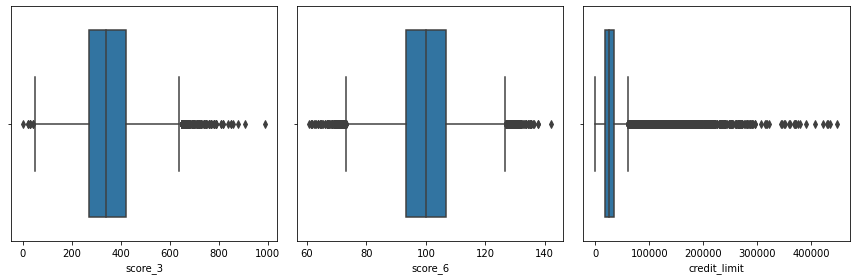

In [ ]:
# Copiando o DataFrame da etapa anterior de valores ausentes para a etapa de outliers
df_outlier = df_nan.copy()

# Plotar os Boxplotes para as variáveis selecionadas
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

sns.boxplot(df_outlier['score_3'], ax=ax[0])
sns.boxplot(df_outlier['score_6'], ax=ax[1])
sns.boxplot(df_outlier['credit_limit'], ax=ax[2])

plt.tight_layout();
# fig.savefig('boxplots')

Os boxplots comprovam a existência de outliers, onde cada ponto além dos limites do boxplot representam as outliers.

Como confirmado a presença de outliers, vamos avançar para a etapa de tratamento.

Primeiramente iremos calcular os limites superiores e inferiores de cada variável com a regra do IQR Score:

In [ ]:
# Definindo a função para o limite superior
def limite_sup(x):
  # Calculando o IQR Score
  q1 = x.quantile(.25) # Primeiro Quartil(25%)
  q3 = x.quantile(.75) # Terceiro Quartil(75%)
  IQR_Score = q3 - q1

  # Definindo os limites superiores
  superior = q3 + 1.5 * IQR_Score
 
  return superior

# Definindo a função para o limite inferior
def limite_inf(x):
  # Calculando o IQR Score
  q1 = x.quantile(.25) # Primeiro Quartil(25%)
  q3 = x.quantile(.75) # Terceiro Quartil(75%)
  IQR_Score = q3 - q1

  # Definindo os limites inferiores
  inferior = q1 - 1.5 * IQR_Score
 
  return inferior

Tendo as funções de cálculo preparadas, vamos avaliar algumas perguntas:
* Seria benéfico remover as outliers?;
* Se a resposta acima tiver resultados negativos, qual seria a opção alternativa?.

Vamos fazer os testes e escolher a melhor abordagem para nosso projeto:


In [ ]:
# Copiando o DataFrame para testes
df_outlier_remocao = df_outlier.copy()

# Removendo os dados
## Definindo a função para remover as outliers
def limpeza_outlier(x):
  a = df_outlier_remocao
  a.drop(a[x > limite_sup(x)].index, axis=0, inplace= True) #remover os dados acima do limite superior
  a.drop(a[x < limite_inf(x)].index, axis=0, inplace= True) #remover os dados abaixo do limite inferior
  return

## Criando uma lista com as variáveis numéricas
lista_numerica = [df_outlier_remocao.score_3,
                  df_outlier_remocao.score_4,
                  df_outlier_remocao.score_5,
                  df_outlier_remocao.score_6,
                  df_outlier_remocao.risk_rate,
                  df_outlier_remocao.last_amount_borrowed,
                  df_outlier_remocao.last_borrowed_in_months,
                  df_outlier_remocao.credit_limit,
                  df_outlier_remocao.income,
                  df_outlier_remocao.ok_since,
                  df_outlier_remocao.n_bankruptcies,
                  df_outlier_remocao.n_defaulted_loans,
                  df_outlier_remocao.n_accounts,
                  df_outlier_remocao.n_issues,
                  df_outlier_remocao.application_time_in_funnel,
                  df_outlier_remocao.external_data_provider_credit_checks_last_month,
                  df_outlier_remocao.external_data_provider_credit_checks_last_year,
                  df_outlier_remocao.external_data_provider_email_seen_before,
                  df_outlier_remocao.external_data_provider_fraud_score,
                  df_outlier_remocao.reported_income,
                  df_outlier_remocao.shipping_zip_code]

## Criando um loop para executar a função de limpeza das outliers
for i in lista_numerica:
  limpeza_outlier(i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: 

Tendo removido as outliers das variáveis numéricas, vamos checar o tamanho do novo dataset:

In [ ]:
# Checando o tamanho do dataset após as remoções
df_outlier_remocao.shape

(11557, 35)

In [ ]:
# Checando o tamanho do dataset da etapa anterior
df_nan.shape

(41741, 35)

Temos que o dataset da etapa de dados ausentes possuia quase 41,7 mil entradas, depois de removermos as outliers, ficamos com apenas 11,5 mil entradas.

Vamos checar essa proporção:

In [ ]:
# Proporção dos datasets
dados_perdidos = df_nan.shape[0] - df_outlier_remocao.shape[0]
dados_perdidos / df_nan.shape[0]

0.7231259433171222

Com a remoção das outliers, perdemos 72% de informação de todo o dataset, o que é extremamente prejudicial para nosso modelo e para qualquer análise que busca representar cenários reais.

Dessa forma devemos encontrar outras abordagens para o tratamento das outliers, e algumas delas são:
* Imputação: (substituir as outliers pelos valores obtidos na detecção de outliers, que no nosso caso são os valores obtidos pelo método IQR)
 * Média;
 * Mediana;
 * Limites superior e inferior.

* Transformação:
 * Escalando os dados; (Scaling)
 * Transformação Logarítmica; (Log transformation)
 * Normalização por raiz quadrada. (Cube Root Normalization)

* Clusterização ou Agrupamento; (Clustering)

* Tratar separadamente;

* Usar modelos de Aprendizado de Máquina (Machine Learning) que não sejam sensíveis à outliers.

Para o projeto, vamos testar o desempenho do modelo para algumas dessas abordagens e no fim fazer uma comparação, para escolhermos o que teve melhor desempenho.

---------------------------------------------

EXTRA: 

Caso tenha interesse em conhecer mais sobre essas abordagens, na seção de referências encontram-se links para excelentes artigos que aprofundam em cada uma, com exemplos e explicações. 

---------------------------------------------

As abordagens que serão testadas são:
* Imputação; e
* Transformação.

Como precisaremos fazer os testes dessas abordagens em cima do nosso modelo, a fim de encontrarmos a melhor, iremos avançar para as próximas etapas de preparação do modelo e mais adiante voltar ao assunto das outliers. 


## Feature Engineering

Nesta etapa vamos obter as variáveis binárias e categóricas, além de buscar novas variáveis que podem ser obtidas com os dados, a fim de alimentar o modelo com mais informações.

Primeiramente vamos criar um dataset para esta etapa:

In [ ]:
# Copiando o Dataframe da etapa anterior
df_feature = df_outlier.copy()

### Obtendo as variáveis binárias e categóricas

Na fase da análise superficial dos dados vimos que existem variáveis categóricas e binárias, e como a maioria dos modelos de Machine Learning (Aprendizado de Máquina) não conseguem interpretar valores não numéricos (entradas em forma de texto), precisamos utilizar um método de Encoder para realizar esta transformação, tornando possível a interpretação desses dados pelo modelo.

As variáveis binárias, que possuem apenas dois valores únicos, são:


In [ ]:
# Checando as variáveis binárias
df_feature.nunique().sort_values().head(4)

target_default                                    2
external_data_provider_credit_checks_last_year    2
facebook_profile                                  2
last_borrowed_in_months                           2
dtype: int64

Para transformar as variáveis em binárias, vamos utilizar o método LabelEncoder:

In [ ]:
# Obtendo as variáveis (features) binárias e categóricas
binarias = df_feature.nunique()[df_feature.nunique() == 2].keys().tolist()
categoricas = [col for col in df_feature.select_dtypes('object').keys().tolist() if col not in binarias]

# Utilizando o método LabelEncoder
le = LabelEncoder()
for i in binarias:
  df_feature[i] = le.fit_transform(df_feature[i])

### Analisando o caso das features categóricas

Para as variáveis categóricas, temos que analisar mais profundamente e buscar entender como estão distribuídos os dados, para então decidirmos a melhor maneira de tratá-las.

Quando vamos utilizar os métodos de Encoder, temos que olhar o tipo de categoria da variável: se ela é Ordinal ou Nominal.

Uma categoria Ordinal possui uma hierarquia em seus valores (ordem), ou seja, existe uma correlação, por exemplo, uma variável que contêm Patentes Militares.

Já uma Nominal, não possui nenhuma correlação existente entre seus valores, por exemplo, uma variável que contem animais, em que um Gato não tem correlação nenhuma com uma Girafa.

Sabendo disso, vamos identificar as variáveis categóricas do nosso dataset:


In [ ]:
df_feature.select_dtypes('object').columns

Index(['score_1', 'score_2', 'reason', 'state', 'zip', 'job_name',
       'real_state', 'email', 'marketing_channel', 'shipping_state',
       'profile_tags', 'user_agent'],
      dtype='object')

As variáveis categóricas são:
* `score_1`;
* `score_2`;
* `reason`;
* `state`;
* `zip`;
* `job_name`;
* `real_state`;
* `email`;
* `marketing_channel`;
* `profile_tags`;
* `shipping_state`
* `user_agent`.

Como não temos nenhuma documentação sobre essas variáveis, irei assumir que em nenhuma delas existe uma correlação dos valores, ou seja, irei adotar todas essas variáveis categóricas como nominais.

Adotando-as como nominais, vamos checar a quantidade de valores únicos que existem em cada uma:


In [ ]:
# Checando a quantidade de valores únicos para as variáveis categóricas
df_feature.select_dtypes('object').nunique()

score_1                  7
score_2                 35
reason               14260
state                   50
zip                    823
job_name             30543
real_state               5
email                    6
marketing_channel        9
shipping_state          25
profile_tags         24458
user_agent             297
dtype: int64

Checando a quantidade de valores únicos, vemos que existem features (variáveis) que possuem mais de 10 mil categorias internas, ou seja, nosso dataset possui high cardinality (alta cardinalidade).

Como foi dito que a maioria dos modelos de Machine Learning precisam ter entradas numéricas, cada tipo de Encoder pode afetar um tipo específico de modelo, e o fato de termos um dataset que possui features categóricas com alta cardinalidade, a atenção na escolha do Encoder deve ser ainda maior.

Diversos tipos de Encoders podem ser utilizados para transformar as features categóricas, porém vamos analisar alguns aspectos e depois selecionar as mais viáveis para solucionar este problema:

* O método LabelEncoder: este não é recomendado para features nominais, pois faz com que alguns modelos, como os de regressão, atribuam uma ordem/correlação erroneamente nos dados, assim tendo uma previsão enviesada e com baixa performance.
Porém modelos baseados em árvores de decisão conseguem mesmo com este método, "quebrar" esta correlação (atribuída erroneamente) e obter bons resultados.

* Dois métodos que poderiam solucionar o problema de atribuição de correlação errônea dos dados com o LabelEncoder, são os métodos Dummy e One-Hot Encoder, que transformam cada valor único da categoria em uma nova feature binária, porém estes métodos se aplicados em datasets com muitas features são bastante inviáveis, uma vez que entram no problema conhecido publicamente como a Maldição da Dimensionalidade (Curse of Dimensionality), em que teríamos serios problemas com a performance de um modelo.

* Com os problemas de alta cardinalidade e atribuição falsa de ordem hierárquica, podemos utilizar outros métodos de Encoder:

 * Binary Encoder: converte cada valor único da variável em um número inteiro e então transforma este número para binário, assim reduzindo a dimensionalidade e o custo de computação.

 * Base-N Encoding: este exerce o mesmo resultado que o Binary Encoder, porém podemos alterar a base para números maiores, abrangendo mais dimensionalidade.

 * Hash Encoder: também é capaz de reduzir a dimensionalidade dos dados, porém ao custo da perda de informação analítica, em que as entradas das features convertidas não poderão ser revertidas para seu valor original, assim impossibilitando uma avaliação das features mais impactantes para o modelo. Aqui existe também outra forma de perda de informação, em que em um dataset com várias features, podem ocorrer colisões de valores, ou seja, a entrada de uma feature pode ter o mesmo valor que em outra, entretanto para o modelo, essa perda pode não ser impactante no seu desempenho.

---------------------------------------------

EXTRA: 

Caso tenha interesse em conhecer mais sobre esses e outros métodos, na seção de referências encontram-se links para excelentes artigos que aprofundam em cada uma, com exemplos e explicações. 

Coloquei também uma referência sobre a Maldição da Dimensionalidade (Curse of Dimensionality).

--------------------------------------------- 

Assim como na etapa de tratamento de outliers, vamos precisar testar cada um destes métodos em busca do que obtém o melhor desempenho.

Faremos os testes da seguinte forma:

* Para modelos com base em árvore, utilizaremos o método LabelEncoder; e

* Para modelos sensíveis à correlação dos dados, testaremos com os métodos: Binary Encoder, Base-N Encoder e Hash Encoder.




## Checando os Testes de Hipóteses

Até aqui, vimos que seriam necessários vários testes para encontrarmos a melhor maneira de tratar algumas etapas, sendo elas:

* Etapa de Tratamento de Outliers:

 * Imputação: iremos converter as outliers pelos limites obtidos por IQR;

 * Transformação: iremos testar com dados padronizados e também com dados normalizados;

* Etapa de Feature Engineering:

 * Testaremos os desempenhos dos modelos de Árvore de Decisão (Decision Tree) e Árvores Aleatórias (Random Forest) com o método LabelEncoder;

 * Testaremos os modelos XGBoost e Máquina de Vetor de Suporte (SVM) com os métodos de Encoder:
   * Binary Encoder;
   * Base-N Encoder;
   * Hash Encoder.

Vale ressaltar que ambos os modelos, precisam de uma regularização dos dados, então mesmo durante o teste com Imputação, também aplicaremos a transformação de padronização e normalização.

Outro passo que já podemos adiantar para todos os testes, é checar o balanceamento dos dados.

Vamos checar o balanceamento da variável alvo `target_default`:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

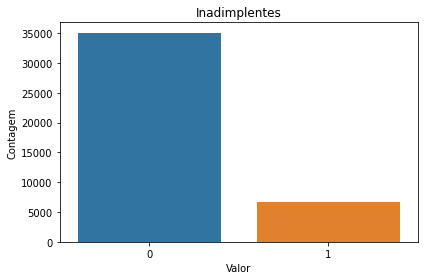

In [ ]:
# Proporção da variável alvo
fig, ax = plt.subplots()

sns.countplot('target_default', data=df_feature, ax=ax)
ax.set_title("Inadimplentes")
ax.set_xlabel("Valor")
ax.set_ylabel("Contagem")

plt.tight_layout()

Com o gráfico, vemos que os dados estão realmente desbalanceados, e para tratar esse desbalanceamento, vamos utilizar o método SMOTE Tomek (referenciado para maiores informações), em que será criado valores sintéticos das classes minoritárias e depois será removido esses valores que estão mais proximos ao limite das duas classes, assim balanceando e aumentando a separação entre elas.


## Roadmap para os Testes de Hipóteses

Para facilitar a visualização dos passos que serão realizados nesta fase de testes, criei um Roadmap que representa cada um destes passos: 

<center><img alt="Roadmap"  src='https://github.com/octavianosilva/Imagens_projetos/blob/main/roadmap_new1.png?raw=true'></center>



Vale ressaltar também que outros testes também seriam possíveis, como fazer testes para tipos de balanceamento, outros tratamentos de outlier, mais modelos de Machine Learning e até com outros tipos de Encoders, porém isso tornaria o projeto ainda mais extendido em busca da "melhor" combinação destes elementos.

# Testes de Hipóteses

Durante essa etapa iremos realizar diversos testes, basicamente um teste para cada caso apresentado no Roadmap, então para evitar o consumo computacional desnecessário, quando um teste for concluído, guardarei os resultados e então evidenciarei o código em forma de texto para evitar ser reexecutado.

Todos os modelos testados serão uma versão básica, ou seja, sem qualquer parametrização que não seja essencial.

Esta etapa envolve testes que demandam bastante tempo de processamento, como em alguns casos mais de 40 minutos para um único teste de modelo, então para evitar termos que passar por todos os passos repetidas vezes, ao fim de cada teste, será escrito o resultado obtido pelos modelos, sem necessidade de re-executar o código.

Caso queira testar mesmo assim, retire as áspas " " " escritas nas primeiras e últimas linhas de cada célula de código.


## Padronização vs Normalização

Testaremos os modelos com os dados regularizados pelo método StandardScaler e normalizados com o MinMaxScaler, além de utilizar a validação cruzada pra evitar o overfitting, que também nos retorna uma avaliação dos modelos, que para fins de teste, será feita com base na métrica acurácia:

In [ ]:
# Criando um dataset para os testes
df_testes = df_feature.copy()

# Validação Cruzada com base na métrica Acurácia - Padronizado
def val_model_padronizado(X, y, clf):
  X = np.array(X) # contém as variáveis independentes
  y = np.array(y) # contem a variável alvo

  pipeline_pd = make_pipeline(StandardScaler(), clf)
  scores_pd = cross_val_score(pipeline_pd, X, y, scoring='accuracy')
  return scores_pd.mean()

# Validação Cruzada com base na métrica Acurácia - Normalizado
def val_model_normalizado(X, y, clf):
  X = np.array(X) # contém as variáveis independentes
  y = np.array(y) # contem a variável alvo

  pipeline_nm = make_pipeline(MinMaxScaler(), clf)
  scores_nm = cross_val_score(pipeline_nm, X, y, scoring='accuracy')
  return scores_nm.mean()

### Imputação

Vamos converter as outliers pelos valores dos limites superiores e inferiores obtidos pelo método IQR Score:

In [ ]:
# Criando um dataset para a imputação
df_imp = df_testes.copy()

## Fazendo as substituições (não foi criado uma função para ler a lista de variáveis, pois estava sofrendo conflito com outras funções)

# Variável score_3
df_imp['score_3'] = np.where(df_imp['score_3'] > limite_sup(df_imp['score_3']), limite_sup(df_imp['score_3']), df_imp['score_3'])
df_imp['score_3'] = np.where(df_imp['score_3'] < limite_inf(df_imp['score_3']), limite_inf(df_imp['score_3']), df_imp['score_3'])

# Variável score_4
df_imp['score_4'] = np.where(df_imp['score_4'] > limite_sup(df_imp['score_4']), limite_sup(df_imp['score_4']), df_imp['score_4'])
df_imp['score_4'] = np.where(df_imp['score_4'] < limite_inf(df_imp['score_4']), limite_inf(df_imp['score_4']), df_imp['score_4'])

# Variável score_5
df_imp['score_5'] = np.where(df_imp['score_5'] > limite_sup(df_imp['score_5']), limite_sup(df_imp['score_5']), df_imp['score_5'])
df_imp['score_5'] = np.where(df_imp['score_5'] < limite_inf(df_imp['score_5']), limite_inf(df_imp['score_5']), df_imp['score_5'])

# Variável score_6
df_imp['score_6'] = np.where(df_imp['score_6'] > limite_sup(df_imp['score_6']), limite_sup(df_imp['score_6']), df_imp['score_6'])
df_imp['score_6'] = np.where(df_imp['score_6'] < limite_inf(df_imp['score_6']), limite_inf(df_imp['score_6']), df_imp['score_6'])

# Variável risk_rate
df_imp['risk_rate'] = np.where(df_imp['risk_rate'] > limite_sup(df_imp['risk_rate']), limite_sup(df_imp['risk_rate']), df_imp['risk_rate'])
df_imp['risk_rate'] = np.where(df_imp['risk_rate'] < limite_inf(df_imp['risk_rate']), limite_inf(df_imp['risk_rate']), df_imp['risk_rate'])

# Variável last_amount_borrowed
df_imp['last_amount_borrowed'] = np.where(df_imp['last_amount_borrowed'] > limite_sup(df_imp['last_amount_borrowed']), limite_sup(df_imp['last_amount_borrowed']), df_imp['last_amount_borrowed'])
df_imp['last_amount_borrowed'] = np.where(df_imp['last_amount_borrowed'] < limite_inf(df_imp['last_amount_borrowed']), limite_inf(df_imp['last_amount_borrowed']), df_imp['last_amount_borrowed'])

# Variável last_borrowed_in_months
df_imp['last_borrowed_in_months'] = np.where(df_imp['last_borrowed_in_months'] > limite_sup(df_imp['last_borrowed_in_months']), limite_sup(df_imp['last_borrowed_in_months']), df_imp['last_borrowed_in_months'])
df_imp['last_borrowed_in_months'] = np.where(df_imp['last_borrowed_in_months'] < limite_inf(df_imp['last_borrowed_in_months']), limite_inf(df_imp['last_borrowed_in_months']), df_imp['last_borrowed_in_months'])

# Variável credit_limit
df_imp['credit_limit'] = np.where(df_imp['credit_limit'] > limite_sup(df_imp['credit_limit']), limite_sup(df_imp['credit_limit']), df_imp['credit_limit'])
df_imp['credit_limit'] = np.where(df_imp['credit_limit'] < limite_inf(df_imp['credit_limit']), limite_inf(df_imp['credit_limit']), df_imp['credit_limit'])

# Variável income
df_imp['income'] = np.where(df_imp['income'] > limite_sup(df_imp['income']), limite_sup(df_imp['income']), df_imp['income'])
df_imp['income'] = np.where(df_imp['income'] < limite_inf(df_imp['income']), limite_inf(df_imp['income']), df_imp['income'])

# Variável ok_since
df_imp['ok_since'] = np.where(df_imp['ok_since'] > limite_sup(df_imp['ok_since']), limite_sup(df_imp['ok_since']), df_imp['ok_since'])
df_imp['ok_since'] = np.where(df_imp['ok_since'] < limite_inf(df_imp['ok_since']), limite_inf(df_imp['ok_since']), df_imp['ok_since'])

# Variável n_bankruptcies
df_imp['n_bankruptcies'] = np.where(df_imp['n_bankruptcies'] > limite_sup(df_imp['n_bankruptcies']), limite_sup(df_imp['n_bankruptcies']), df_imp['n_bankruptcies'])
df_imp['n_bankruptcies'] = np.where(df_imp['n_bankruptcies'] < limite_inf(df_imp['n_bankruptcies']), limite_inf(df_imp['n_bankruptcies']), df_imp['n_bankruptcies'])

# Variável n_defaulted_loans
df_imp['n_defaulted_loans'] = np.where(df_imp['n_defaulted_loans'] > limite_sup(df_imp['n_defaulted_loans']), limite_sup(df_imp['n_defaulted_loans']), df_imp['n_defaulted_loans'])
df_imp['n_defaulted_loans'] = np.where(df_imp['n_defaulted_loans'] < limite_inf(df_imp['n_defaulted_loans']), limite_inf(df_imp['n_defaulted_loans']), df_imp['n_defaulted_loans'])

# Variável n_accounts
df_imp['n_accounts'] = np.where(df_imp['n_accounts'] > limite_sup(df_imp['n_accounts']), limite_sup(df_imp['n_accounts']), df_imp['n_accounts'])
df_imp['n_accounts'] = np.where(df_imp['n_accounts'] < limite_inf(df_imp['n_accounts']), limite_inf(df_imp['n_accounts']), df_imp['n_accounts'])

# Variável n_issues
df_imp['n_issues'] = np.where(df_imp['n_issues'] > limite_sup(df_imp['n_issues']), limite_sup(df_imp['n_issues']), df_imp['n_issues'])
df_imp['n_issues'] = np.where(df_imp['n_issues'] < limite_inf(df_imp['n_issues']), limite_inf(df_imp['n_issues']), df_imp['n_issues'])

# Variável application_time_in_funnel
df_imp['application_time_in_funnel'] = np.where(df_imp['application_time_in_funnel'] > limite_sup(df_imp['application_time_in_funnel']), limite_sup(df_imp['application_time_in_funnel']), df_imp['application_time_in_funnel'])
df_imp['application_time_in_funnel'] = np.where(df_imp['application_time_in_funnel'] < limite_inf(df_imp['application_time_in_funnel']), limite_inf(df_imp['application_time_in_funnel']), df_imp['application_time_in_funnel'])

# Variável external_data_provider_credit_checks_last_month
df_imp['external_data_provider_credit_checks_last_month'] = np.where(df_imp['external_data_provider_credit_checks_last_month'] > limite_sup(df_imp['external_data_provider_credit_checks_last_month']), limite_sup(df_imp['external_data_provider_credit_checks_last_month']), df_imp['external_data_provider_credit_checks_last_month'])
df_imp['external_data_provider_credit_checks_last_month'] = np.where(df_imp['external_data_provider_credit_checks_last_month'] < limite_inf(df_imp['external_data_provider_credit_checks_last_month']), limite_inf(df_imp['external_data_provider_credit_checks_last_month']), df_imp['external_data_provider_credit_checks_last_month'])

# Variável external_data_provider_credit_checks_last_year
df_imp['external_data_provider_credit_checks_last_year'] = np.where(df_imp['external_data_provider_credit_checks_last_year'] > limite_sup(df_imp['external_data_provider_credit_checks_last_year']), limite_sup(df_imp['external_data_provider_credit_checks_last_year']), df_imp['external_data_provider_credit_checks_last_year'])
df_imp['external_data_provider_credit_checks_last_year'] = np.where(df_imp['external_data_provider_credit_checks_last_year'] < limite_inf(df_imp['external_data_provider_credit_checks_last_year']), limite_inf(df_imp['external_data_provider_credit_checks_last_year']), df_imp['external_data_provider_credit_checks_last_year'])

# Variável external_data_provider_email_seen_before
df_imp['external_data_provider_email_seen_before'] = np.where(df_imp['external_data_provider_email_seen_before'] > limite_sup(df_imp['external_data_provider_email_seen_before']), limite_sup(df_imp['external_data_provider_email_seen_before']), df_imp['external_data_provider_email_seen_before'])
df_imp['external_data_provider_email_seen_before'] = np.where(df_imp['external_data_provider_email_seen_before'] < limite_inf(df_imp['external_data_provider_email_seen_before']), limite_inf(df_imp['external_data_provider_email_seen_before']), df_imp['external_data_provider_email_seen_before'])

# Variável external_data_provider_fraud_score
df_imp['external_data_provider_fraud_score'] = np.where(df_imp['external_data_provider_fraud_score'] > limite_sup(df_imp['external_data_provider_fraud_score']), limite_sup(df_imp['external_data_provider_fraud_score']), df_imp['external_data_provider_fraud_score'])
df_imp['external_data_provider_fraud_score'] = np.where(df_imp['external_data_provider_fraud_score'] < limite_inf(df_imp['external_data_provider_fraud_score']), limite_inf(df_imp['external_data_provider_fraud_score']), df_imp['external_data_provider_fraud_score'])

# Variável reported_income
df_imp['reported_income'] = np.where(df_imp['reported_income'] > limite_sup(df_imp['reported_income']), limite_sup(df_imp['reported_income']), df_imp['reported_income'])
df_imp['reported_income'] = np.where(df_imp['reported_income'] < limite_inf(df_imp['reported_income']), limite_inf(df_imp['reported_income']), df_imp['reported_income'])

# Variável shipping_zip_code
df_imp['shipping_zip_code'] = np.where(df_imp['shipping_zip_code'] > limite_sup(df_imp['shipping_zip_code']), limite_sup(df_imp['shipping_zip_code']), df_imp['shipping_zip_code'])
df_imp['shipping_zip_code'] = np.where(df_imp['shipping_zip_code'] < limite_inf(df_imp['shipping_zip_code']), limite_inf(df_imp['shipping_zip_code']), df_imp['shipping_zip_code'])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Vamos verificar se houve a substituição:


<IPython.core.display.Javascript object>

Antes:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

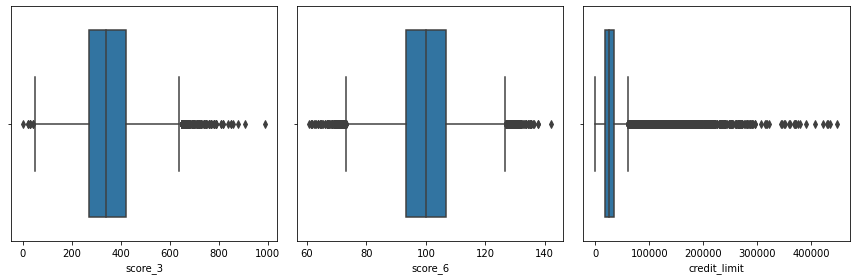

In [ ]:
# Plotar os Boxplotes para as variáveis score_3, score_6 e credit_limit
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

# Boxplot com outliers
print('Antes:')
sns.boxplot(df_testes['score_3'], ax=ax[0])
sns.boxplot(df_testes['score_6'], ax=ax[1])
sns.boxplot(df_testes['credit_limit'], ax=ax[2])

plt.tight_layout();

<IPython.core.display.Javascript object>

Depois das substituições:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

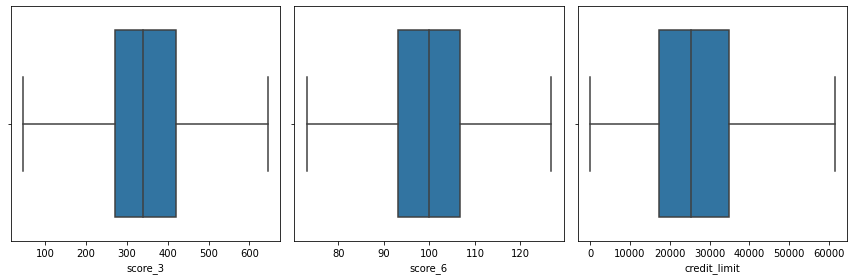

In [ ]:
# Plotar os Boxplotes para as variáveis score_3, score_6 e credit_limit
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

# Boxplot com as substituições 
print('Depois das substituições:')
sns.boxplot(df_imp['score_3'], ax=ax[0])
sns.boxplot(df_imp['score_6'], ax=ax[1])
sns.boxplot(df_imp['credit_limit'], ax=ax[2])

plt.tight_layout();
# fig.savefig('boxplots_imp')

Os valores foram convertidos com sucesso, mas ainda é necessário mais uma análise, dessa vez, vamos checar se houve perdas de informação:

In [ ]:
print('Quantidade de entradas antes das substituições: {}'.format(df_testes.shape[0]))
print('Quantidade de entradas depois das substituições: {}'.format(df_imp.shape[0]))

Quantidade de entradas antes das substituições: 41741
Quantidade de entradas depois das substituições: 41741


Agora que fizemos o tratamento das outliers para este teste e confirmamos que não houveram perdas de informação, vamos avançar para o próximo passo, que é executar as transformações das variáveis categóricas: 

#### Testes utilizando LabelEncoder

In [ ]:
""" (retirar caso queira reproduzir o código)

# Criando um dataframe para este teste
df_le_imp = df_imp.copy() #copiando o DataFrame com os dados imputados

# Obtendo as variáveis categóricas
cat_cols_imp_le = df_le_imp.select_dtypes('object').columns

# Executar o LabelEncoder para cada variável categórica
for col in cat_cols_imp_le:
  df_le_imp[col+'_encoded'] = le.fit_transform(df_le_imp[col])
  df_le_imp.drop(col, axis=1, inplace=True)

"""

" (retirar caso queira reproduzir o código)\n\n# Criando um dataframe para este teste\ndf_le_imp = df_imp.copy() #copiando o DataFrame com os dados imputados\n\n# Obtendo as variáveis categóricas\ncat_cols_imp_le = df_le_imp.select_dtypes('object').columns\n\n# Executar o LabelEncoder para cada variável categórica\nfor col in cat_cols_imp_le:\n  df_le_imp[col+'_encoded'] = le.fit_transform(df_le_imp[col])\n  df_le_imp.drop(col, axis=1, inplace=True)\n\n"

Conferindo se houve a codificação:

In [ ]:
""" (retirar caso queira reproduzir o código)

# Checando as primeiras entradas do DataFrame
df_le_imp.head()

"""

' (retirar caso queira reproduzir o código)\n\n# Checando as primeiras entradas do DataFrame\ndf_le_imp.head()\n\n'

Houve sim a codificação, onde foram criadas novas colunas com sufixo '_encoded', que possuem os valores de texto(tipo objeto) convertidos em números inteiros.

Agora que temos o dataset sem outliers e codificado com o LabelEncoder, vamos separar os dados entre treino e teste, e em seguida, realizar o balanceamento dos dados para a alimentação dos modelos escolhidos:

In [ ]:
""" (retirar caso queira reproduzir o código)

# Separando os dados entre treino e teste
X = df_le_imp.drop('target_default', axis=1)
y = df_le_imp['target_default'] #variável alvo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Executando o balanceamento com SMOTE Tomek
smt = SMOTETomek(random_state=25)
X_smt, y_smt = smt.fit_sample(X_train, y_train)

"""

" (retirar caso queira reproduzir o código)\n\n# Separando os dados entre treino e teste\nX = df_le_imp.drop('target_default', axis=1)\ny = df_le_imp['target_default'] #variável alvo\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)\n\n# Executando o balanceamento com SMOTE Tomek\nsmt = SMOTETomek(random_state=25)\nX_smt, y_smt = smt.fit_sample(X_train, y_train)\n\n"

Checando o balanceamento:

In [ ]:
"""
# Plotando o countplot para a variável target_default
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

sns.countplot('target_default', data=df_feature, ax=ax[0]).set_title('Desbalanceado')
ax[0].set_xlabel("Valor")
ax[0].set_ylabel("Contagem")

sns.countplot(y_smt, ax=ax[1]).set_title('Balanceado')
ax[1].set_xlabel("Valor")
ax[1].set_ylabel("Contagem")

plt.tight_layout();
fig.savefig('target_countplot_balanceamento')

"""

'\n# Plotando o countplot para a variável target_default\nfig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))\n\nsns.countplot(\'target_default\', data=df_feature, ax=ax[0]).set_title(\'Desbalanceado\')\nax[0].set_xlabel("Valor")\nax[0].set_ylabel("Contagem")\n\nsns.countplot(y_smt, ax=ax[1]).set_title(\'Balanceado\')\nax[1].set_xlabel("Valor")\nax[1].set_ylabel("Contagem")\n\nplt.tight_layout();\nfig.savefig(\'target_countplot_balanceamento\')\n\n'

Vemos que o balanceamento funcionou, onde foi realmente criado valores sintéticos para a variável alvo.

Agora podemos testar os modelos escolhidos: Árvores de Decisão (Decision Tree) e Árvores Aleatórias (Random Forest).

Vamos instanciar os modelos e iniciar os testes de validação:

In [ ]:
""" (retirar caso queira reproduzir o código)

# Instanciar os modelos
model_tree = DecisionTreeClassifier() #árvore de decisão
model_rf = RandomForestClassifier() #árvore de decisão

# Realizar a validação cruzada e obter o desempenho dos modelos - Padronizado
df_model_imp_le_pd = [] #criando uma lista para guardar o nome dos modelos
acc_model_imp_le_pd = [] #criando uma lista para guardar os resultados de desempenho

for clf in (model_tree, model_rf):
  df_model_imp_le_pd.append(clf.__class__.__name__)
  acc_model_imp_le_pd.append(val_model_padronizado(X_smt, y_smt, clf))

# Criar um DataFrame para as listas geradas - Padronizado
df_val_imp_le_pd = pd.DataFrame(data=acc_model_imp_le_pd, index=df_model_imp_le_pd, columns=['Acurácia_Padronizado'])



# Realizar a validação cruzada e obter o desempenho dos modelos - Normalizado
df_model_imp_le_nm = [] #criando um DataFrame para guardar o nome dos modelos
acc_model_imp_le_nm = [] #criando um DataFrame para guardar os resultados de desempenho

for clf in (model_tree, model_rf):
  df_model_imp_le_nm.append(clf.__class__.__name__)
  acc_model_imp_le_nm.append(val_model_normalizado(X_smt, y_smt, clf))

# Criar um DataFrame para as listas geradas - Normalizado
df_val_imp_le_nm = pd.DataFrame(data=acc_model_imp_le_nm, index=df_model_imp_le_nm, columns=['Acurácia_Normalizado'])

"""

" (retirar caso queira reproduzir o código)\n\n# Instanciar os modelos\nmodel_tree = DecisionTreeClassifier() #árvore de decisão\nmodel_rf = RandomForestClassifier() #árvore de decisão\n\n# Realizar a validação cruzada e obter o desempenho dos modelos - Padronizado\ndf_model_imp_le_pd = [] #criando uma lista para guardar o nome dos modelos\nacc_model_imp_le_pd = [] #criando uma lista para guardar os resultados de desempenho\n\nfor clf in (model_tree, model_rf):\n  df_model_imp_le_pd.append(clf.__class__.__name__)\n  acc_model_imp_le_pd.append(val_model_padronizado(X_smt, y_smt, clf))\n\n# Criar um DataFrame para as listas geradas - Padronizado\ndf_val_imp_le_pd = pd.DataFrame(data=acc_model_imp_le_pd, index=df_model_imp_le_pd, columns=['Acurácia_Padronizado'])\n\n\n\n# Realizar a validação cruzada e obter o desempenho dos modelos - Normalizado\ndf_model_imp_le_nm = [] #criando um DataFrame para guardar o nome dos modelos\nacc_model_imp_le_nm = [] #criando um DataFrame para guardar os r

Agora que os modelos foram treinados, vamos olhar os resultados pelos DataFrames criados:

In [ ]:
""" (retirar caso queira reproduzir o código)

# Unindo os DataFrames criados
df_val_imp_le = df_val_imp_le_pd.join(df_val_imp_le_nm['Acurácia_Normalizado'])

# Checando o DataFrame com a validação
df_val_imp_le

"""

" (retirar caso queira reproduzir o código)\n\n# Unindo os DataFrames criados\ndf_val_imp_le = df_val_imp_le_pd.join(df_val_imp_le_nm['Acurácia_Normalizado'])\n\n# Checando o DataFrame com a validação\ndf_val_imp_le\n\n"

Temos que o melhor modelo foi o de Árvores Aleatórias (Random Forest) regularizado com a Padronização, porém vale ressaltar que a diferença entre os métodos de regularização (Padronização e Normalização), foi bastante pequena, sendo o resultado: Acurácia de 89.82%.

O melhor modelo de Árvore de Decisão possui 82.07% de acurácia, com o método de regularização de Padronização.

Tempo de validação: 2 minutos.

#### Testes com outros tipos de Encoders

Neste teste faremos a comparação dos modelos XGBoost e SVM (mais especificamente o SVC) com diferentes tipos de Enconders: Binary, Base-N e Hash.

Vamos instanciar os modelos que serão utilizados:

In [ ]:
""" (retirar caso queira reproduzir o código)

# Instanciando os modelos
model_svc = SVC()
model_xgb = XGBClassifier()

"""

' (retirar caso queira reproduzir o código)\n\n# Instanciando os modelos\nmodel_svc = SVC()\nmodel_xgb = XGBClassifier()\n\n'

Agora que os modelos foram instanciados, vamos realizar os testes com diferentes Encoders:

##### Binary Encoder

Será convertido as variáveis categóricas de texto para números inteiros, então convertidos para números binários.

In [ ]:
"""
# Criando um novo DataFrame para este teste
df_encoder_imp_bi = df_imp.copy()

# Obtendo o DataFrame das variáveis numéricas
df_encoder_imp_bi_num = df_encoder_imp_bi.select_dtypes(exclude='object')

## Obtendo as variáveis categóricas para o encoder
df_encoder_imp_bi_cat = df_encoder_imp_bi.select_dtypes('object')

# Instanciando o Binary Encoder e passando as colunas a serem codificadas
bi = ce.BinaryEncoder(cols=['score_1','score_2','reason','state','zip','job_name',
                            'real_state','email','marketing_channel',
                            'shipping_state','profile_tags','user_agent'])

# Executando a codificação
df_bi_imp = bi.fit_transform(df_encoder_imp_bi_cat)

# Criando um novo DataFrame após a codificação
df_bi_imp_resultante = df_encoder_imp_bi_num.join(df_bi_imp)

"""

"\n# Criando um novo DataFrame para este teste\ndf_encoder_imp_bi = df_imp.copy()\n\n# Obtendo o DataFrame das variáveis numéricas\ndf_encoder_imp_bi_num = df_encoder_imp_bi.select_dtypes(exclude='object')\n\n## Obtendo as variáveis categóricas para o encoder\ndf_encoder_imp_bi_cat = df_encoder_imp_bi.select_dtypes('object')\n\n# Instanciando o Binary Encoder e passando as colunas a serem codificadas\nbi = ce.BinaryEncoder(cols=['score_1','score_2','reason','state','zip','job_name',\n                            'real_state','email','marketing_channel',\n                            'shipping_state','profile_tags','user_agent'])\n\n# Executando a codificação\ndf_bi_imp = bi.fit_transform(df_encoder_imp_bi_cat)\n\n# Criando um novo DataFrame após a codificação\ndf_bi_imp_resultante = df_encoder_imp_bi_num.join(df_bi_imp)\n\n"

Vamos checar se houve as transformações:

In [ ]:
"""

# Checando as primeiras entradas do DataFrame
df_bi_imp_resultante.head()

"""

'\n\n# Checando as primeiras entradas do DataFrame\ndf_bi_imp_resultante.head()\n\n'

Podemos confirmar que ocorreu as transformações, porém com este método, foram geradas colunas apenas com valores nulos, as com sufixo '_0', neste caso vamos remover todas essas 12 variáveis nulas.

Cada variável transformada pelo encoder gerou uma própria variável nula, por isso podemos adiantar que são 12.

In [ ]:
"""
# Removendo as variáveis nulas
lista_remocao = ['score_1_0','score_2_0','reason_0','state_0','zip_0','job_name_0',
                'real_state_0','email_0','marketing_channel_0','shipping_state_0',
                'profile_tags_0','user_agent_0']

df_bi_imp_resultante.drop(lista_remocao, axis=1, inplace=True)

# Checando o DataFrame
df_bi_imp_resultante.head()

"""

"\n# Removendo as variáveis nulas\nlista_remocao = ['score_1_0','score_2_0','reason_0','state_0','zip_0','job_name_0',\n                'real_state_0','email_0','marketing_channel_0','shipping_state_0',\n                'profile_tags_0','user_agent_0']\n\ndf_bi_imp_resultante.drop(lista_remocao, axis=1, inplace=True)\n\n# Checando o DataFrame\ndf_bi_imp_resultante.head()\n\n"

Agora já podemos avançar para os testes com os modelos, que serão XGBoost e SVC, mas antes devemos fazer as separações entre treino e teste, além da aplicação do balanceamento.

In [ ]:
"""
# Separando os dados entre treino e teste
X = df_bi_imp_resultante.drop('target_default', axis=1)
y = df_bi_imp_resultante['target_default'] #variável alvo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Executando o balanceamento com SMOTE Tomek
smt = SMOTETomek(random_state=25)
X_smt, y_smt = smt.fit_sample(X_train, y_train)

"""

"\n# Separando os dados entre treino e teste\nX = df_bi_imp_resultante.drop('target_default', axis=1)\ny = df_bi_imp_resultante['target_default'] #variável alvo\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)\n\n# Executando o balanceamento com SMOTE Tomek\nsmt = SMOTETomek(random_state=25)\nX_smt, y_smt = smt.fit_sample(X_train, y_train)\n\n"

Tendo os dados separados e balanceados, vamos avaliar os modelos:

In [ ]:
"""
# Realizar a validação cruzada e obter o desempenho dos modelos - Padronizado
df_model_imp_bi_pd = [] #criando uma lista para guardar o nome dos modelos
acc_model_imp_bi_pd = [] #criando uma lista para guardar os resultados de desempenho

for clf in (model_xgb, model_svc):
  df_model_imp_bi_pd.append(clf.__class__.__name__)
  acc_model_imp_bi_pd.append(val_model_padronizado(X_smt, y_smt, clf))

# Criar um DataFrame para as listas geradas - Padronizado
df_val_imp_bi_pd = pd.DataFrame(data=acc_model_imp_bi_pd, index=df_model_imp_bi_pd, columns=['Acurácia_Padronizado'])



# Realizar a validação cruzada e obter o desempenho dos modelos - Normalizado
df_model_imp_bi_nm = [] #criando um DataFrame para guardar o nome dos modelos
acc_model_imp_bi_nm = [] #criando um DataFrame para guardar os resultados de desempenho

for clf in (model_xgb, model_svc):
  df_model_imp_bi_nm.append(clf.__class__.__name__)
  acc_model_imp_bi_nm.append(val_model_normalizado(X_smt, y_smt, clf))

# Criar um DataFrame para as listas geradas - Normalizado
df_val_imp_bi_nm = pd.DataFrame(data=acc_model_imp_bi_nm, index=df_model_imp_bi_nm, columns=['Acurácia_Normalizado'])

"""

"\n# Realizar a validação cruzada e obter o desempenho dos modelos - Padronizado\ndf_model_imp_bi_pd = [] #criando uma lista para guardar o nome dos modelos\nacc_model_imp_bi_pd = [] #criando uma lista para guardar os resultados de desempenho\n\nfor clf in (model_xgb, model_svc):\n  df_model_imp_bi_pd.append(clf.__class__.__name__)\n  acc_model_imp_bi_pd.append(val_model_padronizado(X_smt, y_smt, clf))\n\n# Criar um DataFrame para as listas geradas - Padronizado\ndf_val_imp_bi_pd = pd.DataFrame(data=acc_model_imp_bi_pd, index=df_model_imp_bi_pd, columns=['Acurácia_Padronizado'])\n\n\n\n# Realizar a validação cruzada e obter o desempenho dos modelos - Normalizado\ndf_model_imp_bi_nm = [] #criando um DataFrame para guardar o nome dos modelos\nacc_model_imp_bi_nm = [] #criando um DataFrame para guardar os resultados de desempenho\n\nfor clf in (model_xgb, model_svc):\n  df_model_imp_bi_nm.append(clf.__class__.__name__)\n  acc_model_imp_bi_nm.append(val_model_normalizado(X_smt, y_smt, clf)

Vamos unir os DataFrames criados para ambas os métodos de regularização:

In [ ]:
"""

# Unindo os DataFrames criados
df_val_imp_bi = df_val_imp_bi_pd.join(df_val_imp_bi_nm['Acurácia_Normalizado'])

# Checando o DataFrame com a validação
df_val_imp_bi

"""

"\n\n# Unindo os DataFrames criados\ndf_val_imp_bi = df_val_imp_bi_pd.join(df_val_imp_bi_nm['Acurácia_Normalizado'])\n\n# Checando o DataFrame com a validação\ndf_val_imp_bi\n\n"

Temos que o melhor modelo foi o XGBoost, obtendo o mesmo valor com ambas as regularizações: Acurácia de 90.06%.

O melhor modelos SVC foi com a Padronização, obtendo 89.29% de acurácia.

Tempo de validação: 1 hora e 47 minutos.

##### Base N Encoder

Aplicando o Base N Encoder, com base 5, este método é semelhante ao Binary Encoder, porém podemos mudar a base:

In [ ]:
"""
# Criando um novo DataFrame para este teste
df_encoder_imp_bn = df_imp.copy()

# Obtendo o DataFrame das variáveis numéricas
df_encoder_imp_bn_num = df_encoder_imp_bn.select_dtypes(exclude='object')

## Obtendo as variáveis categóricas para o encoder
df_encoder_imp_bn_cat = df_encoder_imp_bn.select_dtypes('object')

# Instanciando o Base N Encoder e passando as colunas a serem codificadas
bn = ce.BaseNEncoder(cols=['score_1','score_2','reason','state','zip','job_name',
                            'real_state','email','marketing_channel',
                            'shipping_state','profile_tags','user_agent'], base=5)

# Executando a codificação
df_bn_imp = bn.fit_transform(df_encoder_imp_bn_cat)

# Criando um novo DataFrame após a codificação
df_bn_imp_resultante = df_encoder_imp_bn_num.join(df_bn_imp)
"""

"\n# Criando um novo DataFrame para este teste\ndf_encoder_imp_bn = df_imp.copy()\n\n# Obtendo o DataFrame das variáveis numéricas\ndf_encoder_imp_bn_num = df_encoder_imp_bn.select_dtypes(exclude='object')\n\n## Obtendo as variáveis categóricas para o encoder\ndf_encoder_imp_bn_cat = df_encoder_imp_bn.select_dtypes('object')\n\n# Instanciando o Binary Encoder e passando as colunas a serem codificadas\nbn = ce.BaseNEncoder(cols=['score_1','score_2','reason','state','zip','job_name',\n                            'real_state','email','marketing_channel',\n                            'shipping_state','profile_tags','user_agent'], base=5)\n\n# Executando a codificação\ndf_bn_imp = bn.fit_transform(df_encoder_imp_bn_cat)\n\n# Criando um novo DataFrame após a codificação\ndf_bn_imp_resultante = df_encoder_imp_bn_num.join(df_bn_imp)\n"

Checando o DataFrame:

In [ ]:
"""
# Checando as primeiras entradas do DataFrame
df_bn_imp_resultante.head()
"""

'\n# Checando as primeiras entradas do DataFrame\ndf_bn_imp_resultante.head()\n'

Tembém temos a criação de variáveis com sufixo '_0' que são nulas, então vamos removê-las:

In [ ]:
"""
# Removendo as variáveis nulas
lista_remocao = ['score_1_0','score_2_0','reason_0','state_0','zip_0','job_name_0',
                'real_state_0','email_0','marketing_channel_0','shipping_state_0',
                'profile_tags_0','user_agent_0']

df_bn_imp_resultante.drop(lista_remocao, axis=1, inplace=True)

# Checando o DataFrame
df_bn_imp_resultante.head()
"""

"\n# Removendo as variáveis nulas\nlista_remocao = ['score_1_0','score_2_0','reason_0','state_0','zip_0','job_name_0',\n                'real_state_0','email_0','marketing_channel_0','shipping_state_0',\n                'profile_tags_0','user_agent_0']\n\ndf_bn_imp_resultante.drop(lista_remocao, axis=1, inplace=True)\n\n# Checando o DataFrame\ndf_bn_imp_resultante.head()\n"

Agora vamos avançar para a separação dos dados entre treino e teste, além de executar o balanceamento:

In [ ]:
"""
# Separando os dados entre treino e teste
X = df_bn_imp_resultante.drop('target_default', axis=1)
y = df_bn_imp_resultante['target_default'] #variável alvo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Executando o balanceamento com SMOTE Tomek
smt = SMOTETomek(random_state=25)
X_smt, y_smt = smt.fit_sample(X_train, y_train)
"""

"\n# Separando os dados entre treino e teste\nX = df_bn_imp_resultante.drop('target_default', axis=1)\ny = df_bn_imp_resultante['target_default'] #variável alvo\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)\n\n# Executando o balanceamento com SMOTE Tomek\nsmt = SMOTETomek(random_state=25)\nX_smt, y_smt = smt.fit_sample(X_train, y_train)\n"

Com os dados separados e balanceados, vamos fazer as validações:

In [ ]:
"""
# Realizar a validação cruzada e obter o desempenho dos modelos - Padronizado
df_model_imp_bn_pd = [] #criando uma lista para guardar o nome dos modelos
acc_model_imp_bn_pd = [] #criando uma lista para guardar os resultados de desempenho

for clf in (model_xgb, model_svc):
  df_model_imp_bn_pd.append(clf.__class__.__name__)
  acc_model_imp_bn_pd.append(val_model_padronizado(X_smt, y_smt, clf))

# Criar um DataFrame para as listas geradas - Padronizado
df_val_imp_bn_pd = pd.DataFrame(data=acc_model_imp_bn_pd, index=df_model_imp_bn_pd, columns=['Acurácia_Padronizado'])



# Realizar a validação cruzada e obter o desempenho dos modelos - Normalizado
df_model_imp_bn_nm = [] #criando um DataFrame para guardar o nome dos modelos
acc_model_imp_bn_nm = [] #criando um DataFrame para guardar os resultados de desempenho

for clf in (model_xgb, model_svc):
  df_model_imp_bn_nm.append(clf.__class__.__name__)
  acc_model_imp_bn_nm.append(val_model_normalizado(X_smt, y_smt, clf))

# Criar um DataFrame para as listas geradas - Normalizado
df_val_imp_bn_nm = pd.DataFrame(data=acc_model_imp_bn_nm, index=df_model_imp_bn_nm, columns=['Acurácia_Normalizado'])
"""

"\n# Realizar a validação cruzada e obter o desempenho dos modelos - Padronizado\ndf_model_imp_bn_pd = [] #criando uma lista para guardar o nome dos modelos\nacc_model_imp_bn_pd = [] #criando uma lista para guardar os resultados de desempenho\n\nfor clf in (model_xgb, model_svc):\n  df_model_imp_bn_pd.append(clf.__class__.__name__)\n  acc_model_imp_bn_pd.append(val_model_padronizado(X_smt, y_smt, clf))\n\n# Criar um DataFrame para as listas geradas - Padronizado\ndf_val_imp_bn_pd = pd.DataFrame(data=acc_model_imp_bn_pd, index=df_model_imp_bn_pd, columns=['Acurácia_Padronizado'])\n\n\n\n# Realizar a validação cruzada e obter o desempenho dos modelos - Normalizado\ndf_model_imp_bn_nm = [] #criando um DataFrame para guardar o nome dos modelos\nacc_model_imp_bn_nm = [] #criando um DataFrame para guardar os resultados de desempenho\n\nfor clf in (model_xgb, model_svc):\n  df_model_imp_bn_nm.append(clf.__class__.__name__)\n  acc_model_imp_bn_nm.append(val_model_normalizado(X_smt, y_smt, clf)

Checando o DataFrame:

In [ ]:
"""
# Unindo os DataFrames criados
df_val_imp_bn = df_val_imp_bn_pd.join(df_val_imp_bn_nm['Acurácia_Normalizado'])

# Checando o DataFrame com a validação
df_val_imp_bn
"""

"\n# Unindo os DataFrames criados\ndf_val_imp_bn = df_val_imp_bn_pd.join(df_val_imp_bn_nm['Acurácia_Normalizado'])\n\n# Checando o DataFrame com a validação\ndf_val_imp_bn\n"

Temos que o melhor modelo foi o XGBoost que obteve o mesmo resultado para ambos as regularizações: Acurácia de 89.73%.

O melhor modelo SVC foi com os dados padronizados, com acurácia de 86.5%.

Tempo de validação: 54 minutos.

##### Hash Encoder

Como estamos lidando com features categóricas com alta cardinalidade, vamos utilizar o número de componentes = 32, que é recomendado pela própria documentação:

In [ ]:
"""
# Criando um novo DataFrame para este teste
df_encoder_imp_hs = df_imp.copy()

# Obtendo o DataFrame das variáveis numéricas
df_encoder_imp_hs_num = df_encoder_imp_hs.select_dtypes(exclude='object')

## Obtendo as variáveis categóricas para o encoder
df_encoder_imp_hs_cat = df_encoder_imp_hs.select_dtypes('object')

# Instanciando o Hash Encoder e passando as colunas a serem codificadas
hs = ce.HashingEncoder(cols=['score_1','score_2','reason','state','zip','job_name',
                            'real_state','email','marketing_channel',
                            'shipping_state','profile_tags','user_agent'], n_components=32)

# Executando a codificação
df_imp_hs = hs.fit_transform(df_encoder_imp_hs_cat)

# Criando um novo DataFrame após a codificação
df_imp_hs_resultante = df_encoder_imp_hs_num.join(df_imp_hs)
"""

"\n# Criando um novo DataFrame para este teste\ndf_encoder_imp_hs = df_imp.copy()\n\n# Obtendo o DataFrame das variáveis numéricas\ndf_encoder_imp_hs_num = df_encoder_imp_hs.select_dtypes(exclude='object')\n\n## Obtendo as variáveis categóricas para o encoder\ndf_encoder_imp_hs_cat = df_encoder_imp_hs.select_dtypes('object')\n\n# Instanciando o Binary Encoder e passando as colunas a serem codificadas\nhs = ce.HashingEncoder(cols=['score_1','score_2','reason','state','zip','job_name',\n                            'real_state','email','marketing_channel',\n                            'shipping_state','profile_tags','user_agent'], n_components=32)\n\n# Executando a codificação\ndf_imp_hs = hs.fit_transform(df_encoder_imp_hs_cat)\n\n# Criando um novo DataFrame após a codificação\ndf_imp_hs_resultante = df_encoder_imp_hs_num.join(df_imp_hs)\n"

Checando o DataFrame:

In [ ]:
"""
# Checando o DataFrame
df_imp_hs_resultante.head()
"""

'\n# Checando o DataFrame\ndf_imp_hs_resultante.head()\n'

Como podemos ver, com a conversão perdemos informações sobre quais são as variáveis categóricas obtidas anteriormente, porém agora o modelo consegue lidar com essas variáveis categóricas, além do mais, esse método conseguiu ter o menor número de features entre os testes com os outros enconders, gerando apenas 32 features categóricas.

Vamos então fazer a separação entre os dados de treino e teste, realizar o balanceamento e então validar os modelos:

In [ ]:
"""
# Separando os dados entre treino e teste
X = df_imp_hs_resultante.drop('target_default', axis=1)
y = df_imp_hs_resultante['target_default'] #variável alvo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Executando o balanceamento com SMOTE Tomek
smt = SMOTETomek(random_state=25)
X_smt, y_smt = smt.fit_sample(X_train, y_train)
"""

"\n# Separando os dados entre treino e teste\nX = df_imp_hs_resultante.drop('target_default', axis=1)\ny = df_imp_hs_resultante['target_default'] #variável alvo\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)\n\n# Executando o balanceamento com SMOTE Tomek\nsmt = SMOTETomek(random_state=25)\nX_smt, y_smt = smt.fit_sample(X_train, y_train)\n"

Validando os modelos:

In [ ]:
"""
# Realizar a validação cruzada e obter o desempenho dos modelos - Padronizado
df_model_imp_hs_pd = [] #criando uma lista para guardar o nome dos modelos
acc_model_imp_hs_pd = [] #criando uma lista para guardar os resultados de desempenho

for clf in (model_xgb, model_svc):
  df_model_imp_hs_pd.append(clf.__class__.__name__)
  acc_model_imp_hs_pd.append(val_model_padronizado(X_smt, y_smt, clf))

# Criar um DataFrame para as listas geradas - Padronizado
df_val_imp_hs_pd = pd.DataFrame(data=acc_model_imp_hs_pd, index=df_model_imp_hs_pd, columns=['Acurácia_Padronizado'])



# Realizar a validação cruzada e obter o desempenho dos modelos - Normalizado
df_model_imp_hs_nm = [] #criando um DataFrame para guardar o nome dos modelos
acc_model_imp_hs_nm = [] #criando um DataFrame para guardar os resultados de desempenho

for clf in (model_xgb, model_svc):
  df_model_imp_hs_nm.append(clf.__class__.__name__)
  acc_model_imp_hs_nm.append(val_model_normalizado(X_smt, y_smt, clf))

# Criar um DataFrame para as listas geradas - Normalizado
df_val_imp_hs_nm = pd.DataFrame(data=acc_model_imp_hs_nm, index=df_model_imp_hs_nm, columns=['Acurácia_Normalizado'])
"""

"\n# Realizar a validação cruzada e obter o desempenho dos modelos - Padronizado\ndf_model_imp_hs_pd = [] #criando uma lista para guardar o nome dos modelos\nacc_model_imp_hs_pd = [] #criando uma lista para guardar os resultados de desempenho\n\nfor clf in (model_xgb, model_svc):\n  df_model_imp_hs_pd.append(clf.__class__.__name__)\n  acc_model_imp_hs_pd.append(val_model_padronizado(X_smt, y_smt, clf))\n\n# Criar um DataFrame para as listas geradas - Padronizado\ndf_val_imp_hs_pd = pd.DataFrame(data=acc_model_imp_hs_pd, index=df_model_imp_hs_pd, columns=['Acurácia_Padronizado'])\n\n\n\n# Realizar a validação cruzada e obter o desempenho dos modelos - Normalizado\ndf_model_imp_hs_nm = [] #criando um DataFrame para guardar o nome dos modelos\nacc_model_imp_hs_nm = [] #criando um DataFrame para guardar os resultados de desempenho\n\nfor clf in (model_xgb, model_svc):\n  df_model_imp_hs_nm.append(clf.__class__.__name__)\n  acc_model_imp_hs_nm.append(val_model_normalizado(X_smt, y_smt, clf)

Obtendo os resultados:

In [ ]:
"""
# Unindo os DataFrames criados
df_val_imp_hs = df_val_imp_hs_pd.join(df_val_imp_hs_nm['Acurácia_Normalizado'])

# Checando o DataFrame com a validação
df_val_imp_hs
"""

"\n# Unindo os DataFrames criados\ndf_val_imp_hs = df_val_imp_hs_pd.join(df_val_imp_hs_nm['Acurácia_Normalizado'])\n\n# Checando o DataFrame com a validação\ndf_val_imp_hs\n"

Temos que o melhor modelo foi o XGBoost, que com ambas as regularizações obteve o mesmo resultado: Acurácia de 90.28%.

O melhor modelo SVC obteve acurácia de 85.68% com a regularização de padronização.

Tempo de validação: 42 minutos.

### Apenas com a Regularização

Para esta fase de testes, serão realizados os mesmos passos feitos nos testes com as outliers tratadas por imputação, porém apenas utilizando as regularizações como tratamento das outliers.

Neste caso não entrarei em detalhes novamente sobre cada passo, passarei o código diretamente.

#### Testes utilizando LabelEncoder


In [ ]:
""" (retirar caso queira reproduzir o código)

# Criando um dataframe para este teste
df_le = df_testes.copy() #copiando o DataFrame sem os dados imputados

# Obtendo as variáveis categóricas
cat_cols_balanceado_le = df_le.select_dtypes('object').columns

# Executar o LabelEncoder para cada variável categórica
for col in cat_cols_balanceado_le:
  df_le[col+'_encoded'] = le.fit_transform(df_le[col])
  df_le.drop(col, axis=1, inplace=True)

# Separando os dados entre treino e teste
X = df_le.drop('target_default', axis=1)
y = df_le['target_default'] #variável alvo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Executando o balanceamento com SMOTE Tomek
smt = SMOTETomek(random_state=25)
X_smt, y_smt = smt.fit_sample(X_train, y_train)

# Instanciar os modelos
model_tree = DecisionTreeClassifier() #árvore de decisão
model_rf = RandomForestClassifier() #árvore de decisão

# Realizar a validação cruzada e obter o desempenho dos modelos - Padronizado
df_model_le_pd = [] #criando uma lista para guardar o nome dos modelos
acc_model_le_pd = [] #criando uma lista para guardar os resultados de desempenho

for clf in (model_tree, model_rf):
  df_model_le_pd.append(clf.__class__.__name__)
  acc_model_le_pd.append(val_model_padronizado(X_smt, y_smt, clf))

# Criar um DataFrame para as listas geradas - Padronizado
df_val_le_pd = pd.DataFrame(data=acc_model_le_pd, index=df_model_le_pd, columns=['Acurácia_Padronizado'])

# Realizar a validação cruzada e obter o desempenho dos modelos - Normalizado
df_model_le_nm = [] #criando um DataFrame para guardar o nome dos modelos
acc_model_le_nm = [] #criando um DataFrame para guardar os resultados de desempenho

for clf in (model_tree, model_rf):
  df_model_le_nm.append(clf.__class__.__name__)
  acc_model_le_nm.append(val_model_normalizado(X_smt, y_smt, clf))

# Criar um DataFrame para as listas geradas - Normalizado
df_val_le_nm = pd.DataFrame(data=acc_model_le_nm, index=df_model_le_nm, columns=['Acurácia_Normalizado'])

# Unindo os DataFrames criados
df_val_le = df_val_le_pd.join(df_val_le_nm['Acurácia_Normalizado'])

# Checando o DataFrame com a validação
df_val_le

"""

" (retirar caso queira reproduzir o código)\n\n# Criando um dataframe para este teste\ndf_le = df_testes.copy() #copiando o DataFrame sem os dados imputados\n\n# Obtendo as variáveis categóricas\ncat_cols_balanceado_le = df_le.select_dtypes('object').columns\n\n# Executar o LabelEncoder para cada variável categórica\nfor col in cat_cols_balanceado_le:\n  df_le[col+'_encoded'] = le.fit_transform(df_le[col])\n  df_le.drop(col, axis=1, inplace=True)\n\n# Separando os dados entre treino e teste\nX = df_le.drop('target_default', axis=1)\ny = df_le['target_default'] #variável alvo\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)\n\n# Executando o balanceamento com SMOTE Tomek\nsmt = SMOTETomek(random_state=25)\nX_smt, y_smt = smt.fit_sample(X_train, y_train)\n\n# Instanciar os modelos\nmodel_tree = DecisionTreeClassifier() #árvore de decisão\nmodel_rf = RandomForestClassifier() #árvore de decisão\n\n# Realizar a validação cruzada e obter o desempenho dos modelos -

Temos que o melhor modelo foi o de Árvores Aleatórias (Random Forest) regularizado com a Padronização: Acurácia de 89.53%.

O melhor modelo de Árvore de Decisão obteve 82.22% de acurácia, com a Normalização.

Tempo de validação: 3 minutos.

Interessante notar que os resultados foram bem próximos entre os teste com a imputação e sem a imputação, o que era esperado, uma vez que esses dois modelos de árvores, são robustos à outliers, ou seja, não são muito influênciados por elas.

#### Testes com outros tipos de Encoders


##### Binary Encoder


In [ ]:
"""

# Criando um novo DataFrame para este teste
df_encoder_bi = df_testes.copy()

# Obtendo o DataFrame das variáveis numéricas
df_encoder_bi_num = df_encoder_bi.select_dtypes(exclude='object')

## Obtendo as variáveis categóricas para o encoder
df_encoder_bi_cat = df_encoder_bi.select_dtypes('object')

# Instanciando o Binary Encoder e passando as colunas a serem codificadas
bi = ce.BinaryEncoder(cols=['score_1','score_2','reason','state','zip','job_name',
                            'real_state','email','marketing_channel',
                            'shipping_state','profile_tags','user_agent'])

# Executando a codificação
df_bi = bi.fit_transform(df_encoder_bi_cat)

# Criando um novo DataFrame após a codificação
df_bi_resultante = df_encoder_bi_num.join(df_bi)

# Separando os dados entre treino e teste
X = df_bi_resultante.drop('target_default', axis=1)
y = df_bi_resultante['target_default'] #variável alvo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Executando o balanceamento com SMOTE Tomek
smt = SMOTETomek(random_state=25)
X_smt, y_smt = smt.fit_sample(X_train, y_train)

# Realizar a validação cruzada e obter o desempenho dos modelos - Padronizado
df_model_bi_pd = [] #criando uma lista para guardar o nome dos modelos
acc_model_bi_pd = [] #criando uma lista para guardar os resultados de desempenho

for clf in (model_xgb, model_svc):
  df_model_bi_pd.append(clf.__class__.__name__)
  acc_model_bi_pd.append(val_model_padronizado(X_smt, y_smt, clf))

# Criar um DataFrame para as listas geradas - Padronizado
df_val_bi_pd = pd.DataFrame(data=acc_model_bi_pd, index=df_model_bi_pd, columns=['Acurácia_Padronizado'])



# Realizar a validação cruzada e obter o desempenho dos modelos - Normalizado
df_model_bi_nm = [] #criando um DataFrame para guardar o nome dos modelos
acc_model_bi_nm = [] #criando um DataFrame para guardar os resultados de desempenho

for clf in (model_xgb, model_svc):
  df_model_bi_nm.append(clf.__class__.__name__)
  acc_model_bi_nm.append(val_model_normalizado(X_smt, y_smt, clf))

# Criar um DataFrame para as listas geradas - Normalizado
df_val_bi_nm = pd.DataFrame(data=acc_model_bi_nm, index=df_model_bi_nm, columns=['Acurácia_Normalizado'])

# Unindo os DataFrames criados
df_val_bi = df_val_bi_pd.join(df_val_bi_nm['Acurácia_Normalizado'])

# Checando o DataFrame com a validação
df_val_bi

"""

"\n\n# Criando um novo DataFrame para este teste\ndf_encoder_bi = df_testes.copy()\n\n# Obtendo o DataFrame das variáveis numéricas\ndf_encoder_bi_num = df_encoder_bi.select_dtypes(exclude='object')\n\n## Obtendo as variáveis categóricas para o encoder\ndf_encoder_bi_cat = df_encoder_bi.select_dtypes('object')\n\n# Instanciando o Binary Encoder e passando as colunas a serem codificadas\nbi = ce.BinaryEncoder(cols=['score_1','score_2','reason','state','zip','job_name',\n                            'real_state','email','marketing_channel',\n                            'shipping_state','profile_tags','user_agent'])\n\n# Executando a codificação\ndf_bi = bi.fit_transform(df_encoder_bi_cat)\n\n# Criando um novo DataFrame após a codificação\ndf_bi_resultante = df_encoder_bi_num.join(df_bi)\n\n# Separando os dados entre treino e teste\nX = df_bi_resultante.drop('target_default', axis=1)\ny = df_bi_resultante['target_default'] #variável alvo\n\nX_train, X_test, y_train, y_test = train_test_spl

Temos que o melhor modelo foi o XGBoost regularizado com a Padronização: Acurácia de 89.99%.

O melhor modelo SVC obteve 88.98% com os dados normalizados.

Tempo de validação: 2 horas.

##### Base N Encoder

Vamos utilizar a mesma base 5 para o encoder:

In [ ]:
"""
# Criando um novo DataFrame para este teste
df_encoder_bn = df_testes.copy()

# Obtendo o DataFrame das variáveis numéricas
df_encoder_bn_num = df_encoder_bn.select_dtypes(exclude='object')

## Obtendo as variáveis categóricas para o encoder
df_encoder_bn_cat = df_encoder_bn.select_dtypes('object')

# Instanciando o Base N Encoder e passando as colunas a serem codificadas
bn = ce.BaseNEncoder(cols=['score_1','score_2','reason','state','zip','job_name',
                            'real_state','email','marketing_channel',
                            'shipping_state','profile_tags','user_agent'], base=5)

# Executando a codificação
df_bn = bn.fit_transform(df_encoder_bn_cat)

# Criando um novo DataFrame após a codificação
df_bn_resultante = df_encoder_bn_num.join(df_bn)

# Removendo as variáveis nulas
lista_remocao = ['score_1_0','score_2_0','reason_0','state_0','zip_0','job_name_0',
                'real_state_0','email_0','marketing_channel_0','shipping_state_0',
                'profile_tags_0','user_agent_0']

df_bn_resultante.drop(lista_remocao, axis=1, inplace=True)

# Separando os dados entre treino e teste
X = df_bn_resultante.drop('target_default', axis=1)
y = df_bn_resultante['target_default'] #variável alvo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Executando o balanceamento com SMOTE Tomek
smt = SMOTETomek(random_state=25)
X_smt, y_smt = smt.fit_sample(X_train, y_train)

# Realizar a validação cruzada e obter o desempenho dos modelos - Padronizado
df_model_bn_pd = [] #criando uma lista para guardar o nome dos modelos
acc_model_bn_pd = [] #criando uma lista para guardar os resultados de desempenho

for clf in (model_xgb, model_svc):
  df_model_bn_pd.append(clf.__class__.__name__)
  acc_model_bn_pd.append(val_model_padronizado(X_smt, y_smt, clf))

# Criar um DataFrame para as listas geradas - Padronizado
df_val_bn_pd = pd.DataFrame(data=acc_model_bn_pd, index=df_model_bn_pd, columns=['Acurácia_Padronizado'])



# Realizar a validação cruzada e obter o desempenho dos modelos - Normalizado
df_model_bn_nm = [] #criando um DataFrame para guardar o nome dos modelos
acc_model_bn_nm = [] #criando um DataFrame para guardar os resultados de desempenho

for clf in (model_xgb, model_svc):
  df_model_bn_nm.append(clf.__class__.__name__)
  acc_model_bn_nm.append(val_model_normalizado(X_smt, y_smt, clf))

# Criar um DataFrame para as listas geradas - Normalizado
df_val_bn_nm = pd.DataFrame(data=acc_model_bn_nm, index=df_model_bn_nm, columns=['Acurácia_Normalizado'])

# Unindo os DataFrames criados
df_val_bn = df_val_bn_pd.join(df_val_bn_nm['Acurácia_Normalizado'])

# Checando o DataFrame com a validação
df_val_bn
"""

"\n# Criando um novo DataFrame para este teste\ndf_encoder_bn = df_testes.copy()\n\n# Obtendo o DataFrame das variáveis numéricas\ndf_encoder_bn_num = df_encoder_bn.select_dtypes(exclude='object')\n\n## Obtendo as variáveis categóricas para o encoder\ndf_encoder_bn_cat = df_encoder_bn.select_dtypes('object')\n\n# Instanciando o Binary Encoder e passando as colunas a serem codificadas\nbn = ce.BaseNEncoder(cols=['score_1','score_2','reason','state','zip','job_name',\n                            'real_state','email','marketing_channel',\n                            'shipping_state','profile_tags','user_agent'], base=5)\n\n# Executando a codificação\ndf_bn = bn.fit_transform(df_encoder_bn_cat)\n\n# Criando um novo DataFrame após a codificação\ndf_bn_resultante = df_encoder_bn_num.join(df_bn)\n\n# Removendo as variáveis nulas\nlista_remocao = ['score_1_0','score_2_0','reason_0','state_0','zip_0','job_name_0',\n                'real_state_0','email_0','marketing_channel_0','shipping_state_0

Temos que o melhor modelo foi o XGBoost regularizado com a Normalização: Acurácia de 89.61%, embora a diferença para Padronização foi de 0.0018%.

O melhor modelo SVC obteve 86.86% de acurácia com a regularização Padronizado.

Tempo de validação: 54 minutos.

##### Hash Encoder

In [ ]:
"""
# Criando um novo DataFrame para este teste
df_encoder_hs = df_testes.copy()

# Obtendo o DataFrame das variáveis numéricas
df_encoder_hs_num = df_encoder_hs.select_dtypes(exclude='object')

## Obtendo as variáveis categóricas para o encoder
df_encoder_hs_cat = df_encoder_hs.select_dtypes('object')

# Instanciando o Hash Encoder e passando as colunas a serem codificadas
hs = ce.HashingEncoder(cols=['score_1','score_2','reason','state','zip','job_name',
                            'real_state','email','marketing_channel',
                            'shipping_state','profile_tags','user_agent'], n_components=32)

# Executando a codificação
df_hs = hs.fit_transform(df_encoder_hs_cat)

# Criando um novo DataFrame após a codificação
df_hs_resultante = df_encoder_hs_num.join(df_hs)

# Separando os dados entre treino e teste
X = df_hs_resultante.drop('target_default', axis=1)
y = df_hs_resultante['target_default'] #variável alvo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Executando o balanceamento com SMOTE Tomek
smt = SMOTETomek(random_state=25)
X_smt, y_smt = smt.fit_sample(X_train, y_train)

# Realizar a validação cruzada e obter o desempenho dos modelos - Padronizado
df_model_hs_pd = [] #criando uma lista para guardar o nome dos modelos
acc_model_hs_pd = [] #criando uma lista para guardar os resultados de desempenho

for clf in (model_xgb, model_svc):
  df_model_hs_pd.append(clf.__class__.__name__)
  acc_model_hs_pd.append(val_model_padronizado(X_smt, y_smt, clf))

# Criar um DataFrame para as listas geradas - Padronizado
df_val_hs_pd = pd.DataFrame(data=acc_model_hs_pd, index=df_model_hs_pd, columns=['Acurácia_Padronizado'])



# Realizar a validação cruzada e obter o desempenho dos modelos - Normalizado
df_model_hs_nm = [] #criando um DataFrame para guardar o nome dos modelos
acc_model_hs_nm = [] #criando um DataFrame para guardar os resultados de desempenho

for clf in (model_xgb, model_svc):
  df_model_hs_nm.append(clf.__class__.__name__)
  acc_model_hs_nm.append(val_model_normalizado(X_smt, y_smt, clf))

# Criar um DataFrame para as listas geradas - Normalizado
df_val_hs_nm = pd.DataFrame(data=acc_model_hs_nm, index=df_model_hs_nm, columns=['Acurácia_Normalizado'])

# Unindo os DataFrames criados
df_val_hs = df_val_hs_pd.join(df_val_hs_nm['Acurácia_Normalizado'])

# Checando o DataFrame com a validação
df_val_hs
"""

"\n# Criando um novo DataFrame para este teste\ndf_encoder_hs = df_testes.copy()\n\n# Obtendo o DataFrame das variáveis numéricas\ndf_encoder_hs_num = df_encoder_hs.select_dtypes(exclude='object')\n\n## Obtendo as variáveis categóricas para o encoder\ndf_encoder_hs_cat = df_encoder_hs.select_dtypes('object')\n\n# Instanciando o Binary Encoder e passando as colunas a serem codificadas\nhs = ce.HashingEncoder(cols=['score_1','score_2','reason','state','zip','job_name',\n                            'real_state','email','marketing_channel',\n                            'shipping_state','profile_tags','user_agent'], n_components=32)\n\n# Executando a codificação\ndf_hs = hs.fit_transform(df_encoder_hs_cat)\n\n# Criando um novo DataFrame após a codificação\ndf_hs_resultante = df_encoder_hs_num.join(df_hs)\n\n# Separando os dados entre treino e teste\nX = df_hs_resultante.drop('target_default', axis=1)\ny = df_hs_resultante['target_default'] #variável alvo\n\nX_train, X_test, y_train, y_test 

Temos que o melhor modelo foi o XGBoost regularizado com a Padronização: Acurácia de 90.15%, embora a diferença entre as regularizações foi de apenas 0.0037%.

O melhor modelo SVC obteve 85.38% de acurácia com a Padronização.

Tempo de validação: 43 minutos.

# Resultado Final do Teste de Hipótese

Realizando todos os testes, é possível ver que os modelos que foram alimentados com os dados sendo imputados e regularizados, obtiveram desempenhos melhores que os que apenas passaram pela regularização, embora as diferenças entre os desempenhos sejam bastante pequenas.

Vale lembrar que embora o modelo Random Forest obteve melhor resultado através da Padronização, devemos ter em mente que a diferença entre os métodos de regularização (Padronização e Normalização) foi bastante pequena.

Dito isso, vamos organizar os resultados obtidos então, pelas etapas que envolviam a Imputação como tratamento de outliers:

In [ ]:
# Criando um DataFrame para os resultados
df_resultados_testes = pd.DataFrame([['Random Forest',89.82, 'Padronizado', '2 minutos'], 
                                    ['XGBoost',90.06, 'Ambos', '1 hora e 47 minutos'],
                                    ['XGBoost',89.73, 'Ambos', '54 minutos'],
                                    ['XGBoost',90.28, 'Ambos','42 minutos']],
                                    index=['LabelEncoder','BinaryEncoder',
                                           'BaseNEncoder','HashEncoder'], 
                                    columns=['Modelo','Acurácia (%)','Regularização',
                                           'Tempo de Validação'])
# Chamando o DataFrame com os resultados
df_resultados_testes

<IPython.core.display.Javascript object>

,Modelo,Acurácia (%),Regularização,Tempo de Validação
LabelEncoder,Random Forest,89.82,Padronizado,2 minutos
BinaryEncoder,XGBoost,90.06,Ambos,1 hora e 47 minutos
BaseNEncoder,XGBoost,89.73,Ambos,54 minutos
HashEncoder,XGBoost,90.28,Ambos,42 minutos


Com o resultado dos testes, podemos concluir que todos os modelos testados obtiveram desempenhos bem próximos, mas cada um precisou de um tempo diferente para ser testado.

Olhando pelo tempo gasto, o modelo Random Forest (Árvores Aleatórias) se saiu extremamente superior ao XGBoost para o nosso conjunto de dados, onde foi inferior apenas por 0,46% de acurácia, mas foi 95% mais rápido no processamento.

Outra vantagem de se utilizar o modelo Random Forest (Árvores Aleatórias) ao contrário do XGBoost em questão, é que ainda podemos obter informações de quais variáveis são relevantes para o modelo, o que o Hashing Encoding feito no XGBoost impossibilita essa análise.

Agora que temos o modelo Random Forest como o escolhido para realizar a previsão dos clientes que possam se tornar 'default', vamos avançar para outra etapa bastante importante: a Otimização dos Hiperparâmetros do modelo.

# Otimização de Hiperparâmetros

Esta etapa é bastante importante quando desenvolvemos modelos de Machine Learning (Aprendizado de Máquina), pois os testes foram realizados por uma versão 'crua' deles, agora podemos fazer o tunning de seus hiperparâmetros para obtermos desempenhos ainda maiores do modelo, além de reduzir ainda mais as chances de overfitting.

Para encontrar a melhor combinação de hiperparâmetros do modelo Random Forest (Árvores Aleatórias), vamos utilizar o método GridSearch.

Antes de realizarmos a pesquisa dos hiperparâmetros, precisamos preparar novamente os dados que serão utilizados a partir de agora, que será:

* Utilizar o dataset com os dados imputados;
* Realizar a codificação das variáveis categóricas com LabelEncoder;
* Separar os dados de treino e teste;
* Realizar a Padronização dos dados de treino; e
* Realizar o balanceamento com SMOTE Tomek nos dados de treino.


In [ ]:
# Copiar o dataset imputado para esta etapa
df_tunning = df_imp.copy()

# Instanciando o LabelEncoder
le = LabelEncoder()

# Obtendo as variáveis categóricas
cat_cols_tunning = df_tunning.select_dtypes('object').columns

# Executar o LabelEncoder para cada variável categórica
for col in cat_cols_tunning:
  df_tunning[col+'_encoded'] = le.fit_transform(df_tunning[col])
  df_tunning.drop(col, axis=1, inplace=True)

# Separando os dados entre treino e teste
X = df_tunning.drop('target_default', axis=1)
y = df_tunning['target_default'] #variável alvo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Aplicando a regularização de padronização nos dados de treino
pad = StandardScaler().fit(X_train)
X_train = pad.transform(X_train)

# Executando o balanceamento com SMOTE Tomek
smt = SMOTETomek(random_state=25)
X_smt, y_smt = smt.fit_sample(X_train, y_train)

<IPython.core.display.Javascript object>

Com os dados tratados, vamos realizar a validação do modelo base de Random Forest (Árvores Aleatórias):

In [ ]:
# Instanciar o modelo Random Forest
model_rf = RandomForestClassifier()

# Treinando um modelo base de Random Forest
pontuacao_rf_base = val_model_padronizado(X_smt, y_smt, model_rf)

# Exibindo o resultado
print('Acurácia do modelo Random Forest base: {:.2f}'.format(pontuacao_rf_base))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Acurácia do modelo Random Forest base: 0.91


A acurácia do modelo Random Forest básico é de 91%.

Agora vamos realizar a pesquisa dos hiperparâmetros para obtermos um desempenho maior do modelo:

In [ ]:
# Fazendo uma lista com os parâmetros que serão usados pelo GridSearch
grid_rf = dict()
grid_rf['n_estimators'] = [51]
# 20,(50),70
# 48,(50),52
# 50,(51)
grid_rf['min_samples_split'] = [2] 
# (2),4,6
grid_rf['min_samples_leaf'] = [1]
# (1),5,10
# (1),2

# Definindo a validação cruzada
cv = StratifiedKFold(n_splits = 10, shuffle = True)

# Definindo a busca do GridSearch
busca = GridSearchCV(model_rf, grid_rf, scoring='accuracy', n_jobs=-1, cv=cv)

# Executando a busca
resultado = busca.fit(X_smt, y_smt)

# Exibindo os resultados
print("Melhor acurácia: {:.2f}".format(resultado.best_score_))
print("Melhores Hiperparâmetros:", resultado.best_params_)

Temos os melhores hiperparâmetros pra nosso modelo, e ele melhorou 1% apenas com as alterações de parâmetros, essa melhora pode não parecer muito significativa, porém de fato é uma otimização.

Vale lembrar que a otimização foi pouca, devido aos tratamentos realizados nos dados, esses sim são os mais impactantes para melhorar a qualidade do modelo, então quando tentamos melhorar algo que já está bom, as melhorias podem parecer poucas, mas ainda são muito bem vindas. Isso reforça a importância das etapas de tratamento dos dados, afinal dados bem tratados refletem em bons modelos. 

Agora vamos instanciar um novo modelo Random Forest, aplicando as mudanças nos seus hiperperâmetros:

In [ ]:
# Instanciando o modelo tunado
model_rf_tunned = RandomForestClassifier(n_estimators=51, min_samples_split=2, min_samples_leaf=1)

Até agora, utilizamos apenas a métrica acurácia para avaliar o desempenho de um modelo, mas existem outras métricas como Precisão e Recall que podem ser muito importantes para avaliarmos os impactos do modelo quando implantado.

Entraremos mais a fundo neste assunto, que envolve os problemas com altos números de falsos positivos e negativos para a empresa.

# Trade-Off: Precisão vs. Recall

Quando avaliamos um modelo, devemos ficar atentos as métricas que representam a taxa de falsos positivos e negativos que nosso modelo gera, pois podemos ter um modelo que mais causa prejuízo do que soluciona.

A Precisão nos revela a taxa de falsos positivos que nosso modelo irá prever para o problema, enquanto que o Recall trata o aspecto dos falsos negativos.

O Trade-Off nada mais é que uma troca entre essas variáveis, que são opostas em desempenho, ou seja, quando aumentamos a Precisão para reduzir a taxa de falsos positivos, diminuímos o Recall e aumentamos a quantidade de falsos negativos.

Para entendermos melhor o impacto dessas métricas, vamos analisar este exemplo:

Nosso modelo possui possui 70% de Precisão e 90% de Recall, quando o modelo faz a previsão de 100 clientes, dado a Precisão, 30 clientes serão erroneamente tratados como 'default', assim tendo seus pedidos de créditos rejeitados ou tratar um cliente da empresa como inadimplente por uma falha do modelo. Agora, pelo Recall, de 100 clientes acusados de inadimplência, apenas 10 irão passar pelo pente fino do modelo.

Se tivermos uma Precisão muito baixa, poderemos ter o churn de clientes pelo fato dele ser bastante barrado de forma errada, tendo seus pedidos negados por uma falha do modelo, agora se temos um Recall alto, a empresa ou instituição terá mais segurança em lidar com os inadimplentes.

Para visualizarmos essas métricas, vamos aplicar o Relatório de Classificação para o modelo, e além deste relatório, vamos calcular a Área sob a Curva ROC (AUC), que também é outra métrica bastante interessante para demonstrar o desempenho do modelo, em que quanto mais perto o resultado for de 1.0, melhor é este modelo. Essa métrica também demonstra a chance do modelo em distinguir corretamente entre as classes da variável alvo.

Para complementar o Relatório de Classificação, vamos plotar também a matriz de confusão do modelo.



Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.8844    0.9661    0.9235     28033
           1     0.9627    0.8737    0.9161     28033

    accuracy                         0.9199     56066
   macro avg     0.9236    0.9199    0.9198     56066
weighted avg     0.9236    0.9199    0.9198     56066

AUC: 0.9199



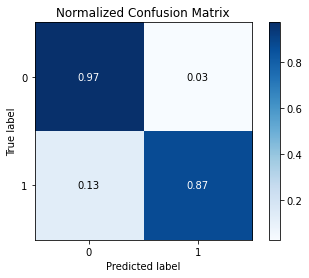

In [ ]:
# Definindo a validação cruzada
cv = StratifiedKFold(n_splits = 10, shuffle = True)

# Previsão
y_pred = cross_val_predict(model_rf_tunned, X_smt, y_smt, cv=cv)

# Relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_smt, y_pred, digits=4))

# Plotar a matriz de confusão
skplt.metrics.plot_confusion_matrix(y_smt, y_pred, normalize=True);
#plt.savefig('matriz_confusao')

# Área sob a curva(AUC)
print('AUC: {:.4f}\n'.format(roc_auc_score(y_smt, y_pred)))

Com o relatório temos várias métricas, como precisão, recall, f1-score e a acurácia.

Até então usamos apenas a métrica acurácia, como métrica de validação dos modelos, porém como nossos dados estão balanceados, ela se torna realmente útil, enquanto que se tivéssemos um dataset desbalanceado, seria melhor avaliar os modelos pela métrica f1-score, que traz um balanceamento melhor entre precisão e recall.

Para nosso modelo treinado e otimizado, obtivemos para a classe alvo(1):
* Precisão: 96%;
* Recall: 87%;
* F1-Score: 91%;
* Acurácia: 92%;
* AUC: 0.92.

Considerando o exemplo anterior sobre o impacto destas métricas, teríamos um modelo que em 100 previsões, dado a precisão de 96%, apenas 4 clientes seriam considerados default erroneamente, enquanto que pelo o recall de 87%, o modelo deixaria passar 13 clientes que realmente são default.

Como foi posto os problemas com falsos negativos, ter um recall de 87% pode parecer ruim, já que para 100 previsões, as empresas terão prejuízos com 13 clientes, mas como foi calculado a Área sob a Curva ROC (AUC), podemos determinar a qualidade do nosso modelo, se mesmo com essa métrica mais baixa ele seria considerado bom ou ruim.

Temos que no geral, modelos que conseguem valores nessa métrica entre 0.7 à 0.8, são considerados aceitáveis, de 0.8 à 0.9 são excelentes, e aqueles que conseguem valores acima de 0.9, como é o nosso caso (0.92), ele é considerado como 'fora da curva' no sentido bom da palavra.

Agora que temos essas informações do modelo treinado e otimizado, vamos realizar o teste final utilizando os dados de teste, que foram separados e que evitamos de usar até agora.

# Validação Final com os dados de teste

Vamos então utilizar os dados de teste para a previsão final do modelo:

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      7041
           1       0.36      0.10      0.15      1308

    accuracy                           0.83      8349
   macro avg       0.61      0.53      0.53      8349
weighted avg       0.78      0.83      0.79      8349

AUC: 0.5322



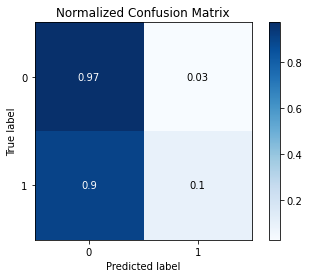

In [ ]:
# Treinando o modelo
model_rf_tunned.fit(X_smt, y_smt)

# Realizar a Padronização nos dados de teste
X_test = pad.transform(X_test)

# Fazendo a previsão com os dados de teste
y_pred_final = model_rf_tunned.predict(X_test)

# Relatório de Classificação
print(classification_report(y_test, y_pred_final))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred_final)))

# plotar matriz de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred_final, normalize=True);

Os resultados são bastante interessantes, testando nosso modelo com os dados de teste, obtivemos um resultado bastante abaixo do esperado.

Por que isso ocorreu? Na verdade esse é um problema até comum quando se trata de dados desbalanceados, onde nosso modelo foi treinado em um ambiente balanceado, porém quando enfrentou dados novos que eram desbalanceados, o que aconteceria em uma situação real do negócio, o modelo não conseguiu obter um bom desempenho.

Temos algumas causas para esse desempenho baixo:
* Nosso modelo sofreu Overfitting; ou
* As amostras de treino ou teste não são representativas;
* Natureza estocástica do modelo utilizado.

Como o objetivo deste projeto era desenvolver um algoritmo de Machine Learning para prever quais clientes se tornariam default, não iremos nos estender em buscar o 'melhor' modelo para lidar com os dados reais, uma vez que cada uma das causas acima necessitam de bastante tempo de pesquisa.

Embora não será feito uma busca pela solução ideal para este problema de desempenho do modelo com os dados de teste, iremos mostrar que nosso modelo sofreu o overfitting.

Vamos repassar pela etapa de Otimização dos Hiperparâmetros, agora fazendo algumas alterações e então fazer a comparação com os dados de treino e teste para a nova parametrização:

Importante lembrar que as células de códigos foram reiniciadas, porém mantemos os resultados já gerados, assim quando fizermos a validação dos dados de teste a seguir, este será usado apenas uma vez:

In [ ]:
# Instanciar o modelo Random Forest
model_rf_teste = RandomForestClassifier(n_estimators=1000, min_samples_split=60, min_samples_leaf=150, max_depth=50)

# Treinando um modelo base de Random Forest
pontuacao_rf_base_teste = val_model_padronizado(X_smt, y_smt, model_rf_teste)

# Exibindo o resultado
print('Acurácia do modelo Random Forest base: {:.2f}'.format(pontuacao_rf_base_teste))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Acurácia do modelo Random Forest base: 0.82


In [ ]:
# Testes Realizados nos seguintes parâmetros
#1 - n_estimators = 500, acurácia de 85%
#2 - n_estimators = 1000, acurácia de 85%
#3 - min_samples_split = 30, acurácia de 85%
#4 - min_samples_split = 60, acurácia de 85%
#5 - min_sample_leaf = 60, acurácia de 84%
#6 - min_sample_leaf = 150, acurácia de 82%
#7 - max_depth = 50, acurácia de 82%

Aqui já notamos uma diferença, o modelo base com os novos parâmetros atingiu 82% de acurácia, contra os 91% obtidos como base para a parametrização anterior.

Vamos plotar o Relatório de Classificação com os dados de treino:

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.8011    0.8802    0.8388     28033
           1     0.8671    0.7815    0.8221     28033

    accuracy                         0.8309     56066
   macro avg     0.8341    0.8309    0.8304     56066
weighted avg     0.8341    0.8309    0.8304     56066

AUC: 0.8309



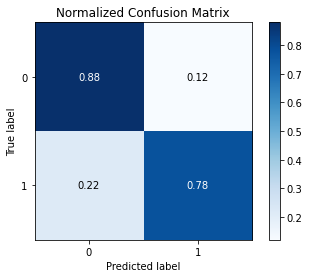

In [ ]:
# Definindo a validação cruzada
cv = StratifiedKFold(n_splits = 10, shuffle = True)

# Previsão
y_pred_test = cross_val_predict(model_rf_teste, X_smt, y_smt, cv=cv)

# Relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_smt, y_pred_test, digits=4))

# Plotar a matriz de confusão
skplt.metrics.plot_confusion_matrix(y_smt, y_pred_test, normalize=True);


# Área sob a curva(AUC)
print('AUC: {:.4f}\n'.format(roc_auc_score(y_smt, y_pred_test)))

In [ ]:
# Resultados obtidos durante os testes
#1 - auc 0.87, precision 0.92, recall 0.81, f1-score 0.86
#2 -  a  0.87,     p     0.92,    r   0.81,    f1    0.86
#3 -  a  0.87,     p     0.92,    r   0.81,    f1    0.86
#4 -  a  0.87,     p     0.91,    r   0.81,    f1    0.86
#5 -  a  0.85,     p     0.90,    r   0.80,    f1    0.85
#6 -  a  0.83,     p     0.86,    r   0.78,    f1    0.82
#7 -  a  0.83,     p     0.86,    r   0.78,    f1    0.82

No ambiente de treino, o desempenho do modelo foi caindo a cada teste de parâmetros.

Agora vamos observar o Relatório de Classificação para a validação do modelo com os dados de teste:

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      7041
           1       0.34      0.30      0.32      1308

    accuracy                           0.80      8349
   macro avg       0.61      0.60      0.60      8349
weighted avg       0.79      0.80      0.79      8349

AUC: 0.5961



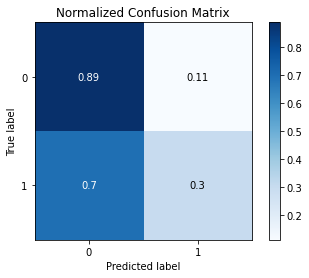

In [ ]:
# Treinando o modelo
model_rf_teste.fit(X_smt, y_smt)

# Realizar a Padronização nos dados de teste
X_test = pad.transform(X_test)

# Fazendo a previsão com os dados de teste
y_pred_final_teste = model_rf_teste.predict(X_test)

# Relatório de Classificação
print(classification_report(y_test, y_pred_final_teste))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred_final_teste)))

# plotar matriz de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred_final_teste, normalize=True);

In [ ]:
# Resultados obtidos durante os testes
#1 - auc 0.57, precision 0.37, recall 0.21, f1-score 0.27
#2 -  a  0.57,     p     0.37,   r    0.21,    f1    0.27
#3 -  a  0.57,     p     0.36,   r    0.21,    f1    0.27
#4 -  a  0.57,     p     0.37,   r    0.21,    f1    0.27
#5 -  a  0.58,     p     0.35,   r    0.24,    f1    0.28
#6 -  a  0.59,     p     0.34,   r    0.30,    f1    0.32 
#7 -  a  0.59,     p     0.34,   r    0.30,    f1    0.32

Podemos perceber que enquanto o modelo no ambiente de treino sofria quedas de desempenho, no ambiente "real", usando os dados de teste, o modelo foi se saindo cada vez melhor.

O que acontece na verdade é que essa queda no desempenho do ambiente de treino, na verdade, é o fato de estarmos generalizando o modelo, assim trazendo-o mais perto de representar a realidade.

Quando fizemos a primeira otimização, utilizamos parâmetros com valores baixos, inclusive `min_samples_leaf` com valor 1, que foi provavelmente a maior causa de overfitting do modelo, em que faz com que o modelo de árvore chegue a ter apenas uma amostra no último nó (folha), assim não tendo generalização nenhuma.

Este foi apenas um exemplo superficial para mostrar que o modelo ao menos sofre com overfitting, lembrando que existem outras formas de tratar o overfitting como: reduzir a complexidade dos dados, realizar outros tratamentos das variáveis categóricas com alta cardinalidade.

Com toda essa análise, é possível perceber que em apenas uma das causas da queda do desempenho com os dados "reais" (dados de teste), já exige muitas pesquisas, e consequentemente bastante tempo.

# Conclusão

Este projeto foi importante para entendermos os impactos das previsões de modelos de Machine Learning (Aprendizado de Máquina), para o problema de inadimplência que as empresas enfrentam todos os dias.

Foi possível desenvolver um modelo de Machine Learning para a previsão de inadimplência dos clientes da empresa, mas embora o resultado final tenha sido baixo, comprovamos que pode ser melhorado com futuras pesquisas e tratamentos.

Durante o desenvolvimento deste projeto, nos deparamos com diversas encruzilhadas, em que para cada etapa, havia várias abordagens possíveis, o que nos fez realizar diversos testes para no fim escolher as melhores através dos resultados obtidos.

O conjunto de dados utilizado neste projeto, foi ótimo para demonstrar os problemas que um Cientista de Dados irá se deparar em seu trabalho, como grandes quantidades de valores discrepantes presentes nos dados, a alta cardinalidade das features categóricas e os problemas em que o modelo não generaliza os dados.

Por fim, busquei passar por várias etapas de tratamento de dados utilizando várias abordagens, mas vale lembrar que existem mais além das que foram apresentadas neste projeto.

Caso tenha críticas ou sugestões, sinta-se à vontade para deixar um comentário.

# Referências

Sobre o problema de inadimplência:

*   https://www.creditas.com/exponencial/analise-de-credito/

*   https://www.contabilize.com/2019/08/02/cuidado-a-inadimplencia-ainda-vai-falir-a-sua-empresa/

Sobre o tratamento de Outliers:

* https://www.bixtecnologia.com/outliers-descubra-o-que-sao-e-como-contorna-los-em-sua-analise-de-dados/

* https://machinelearningmastery.com/robust-scaler-transforms-for-machine-learning/

* https://pub.towardsai.net/handling-outliers-in-machine-learning-f842d8f4c1dc

* https://medium.com/analytics-vidhya/how-to-remove-outliers-for-machine-learning-24620c4657e8

* https://medium.com/analytics-vidhya/how-to-handle-outliers-in-machine-learning-5d8105c708e5

* https://www.neuraldesigner.com/blog/3_methods_to_deal_with_outliers

Sobre os métodos Encoder:

* https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/

* https://www.kaggle.com/alexisbcook/categorical-variables

* https://towardsdatascience.com/high-number-of-unique-values-and-tree-based-models-c30167b63edd

Sobre a Maldição de Dimensionalidade (Curse of Dimensionality):

* https://towardsdatascience.com/the-curse-of-dimensionality-50dc6e49aa1e

Sobre o método de Balanceamento SMOTE:
* https://towardsdatascience.com/stop-using-smote-to-handle-all-your-imbalanced-data-34403399d3be

Sobre a área sob a curva ROC:
* https://www.sciencedirect.com/science/article/pii/S1556086415306043

Sobre a discrepância entre os desempenhos com dados de treino e teste:
* https://machinelearningmastery.com/the-model-performance-mismatch-problem/